# Lab 5: Understanding Variational Autoencoders (VAE)



------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------
PRÁCTICA 1. PARTE 2

DIEGO COLLADO MARTÍN - NIA: 100405606 

DIEGO LÓPEZ LÓPEZ - NIA: 100507210

------------------------------------------------------

In this notebook, you will complete the code to train a VAE for a dataset of images of celebrities: [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We will use a reduced set of 11.000 images to speed things up.


### Probabilistic model

The probabilistic model to fit to the data is exactly the same one seen in class. If $\mathbf{x}^{(i)}$ are the training images and $\mathbf{z}^{(i)}$ are the corresponding latent (unobserved) embeddings of dimension $k$, $i=1,\ldots,11.000$. Then ...

\begin{align}
p(\mathbf{z}) &= \mathcal{N}(\mathbf{0},\mathbf{I})\\
p(\mathbf{x}|\mathbf{z}) &= \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})
\end{align}
where $\mu_\theta(\mathbf{z})$ is a Neural Network with input $\mathbf{z}$ and $\sigma_x$ is a reconstruction noise power that we won't train. By default, we will take the value $\sigma_x=0.1$. 

### Inference model

We will approximate the posterior distribution $p(\mathbf{z}|\mathbf{x})$ by the following parametric model

$$p(\mathbf{z}|\mathbf{x})\approx q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x}))$$

where both $\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x})$ are neural networks with input $\mathbf{x}$.

### Training loss: the evidence lower bound (ELBO)

Since exact inference is intractable in the former model, we will train the parameters of the probabilistic and inference models using the ELBO lower bound

$$\log p(\mathbf{x}) \geq \mathbb{E}_{q(\mathbf{z}|\mathbf{x})}\left[\log p(\mathbf{x}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z}))$$

Since $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$ and $q(\mathbf{z}|\mathbf{x})$ are both Gaussian then

$$D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z})) = \frac{1}{2}\left(-k+\sum_{j=1}^k \sigma_{\eta,j}-\log(\sigma_{\eta,j})+\mu_{\eta,j}^2\right)$$

During training, the first expectation will be replaced by a one-sample Monte Carlo estimate for every data point. Overall, the ELBO to be optimized using SGD is

$$\text{ELBO}(\theta,\eta,\sigma_x) = \frac{1}{N} \sum_{i=1}^{N} \left(\log p(\mathbf{x}^{(i)}|\tilde{\mathbf{z}}^{(i)}) - D_{KL}(q(\mathbf{z}|\mathbf{x}^{(i)}||p(\mathbf{z}))\right)$$

where $\tilde{\mathbf{z}}^{(i)}$ is a sample from $q(\mathbf{z}|\mathbf{x}^{(i)})$ computed as

$$\tilde{\mathbf{z}}^{(i)} =  \mu_\eta(\mathbf{x}) + \sqrt{\sigma_\eta(\mathbf{x})} \epsilon$$
and $\epsilon$ is a sample from a k-dimensional standard Gaussian distribution. This is the **reparameterization trick**. Note that samples are differentiable w.r.t. the parameters in both $\mu_\eta(\mathbf{x})$ and $\sigma_\eta(\mathbf{x})$.

Explicación para hacerme a la idea bien de la teoría:

La idea es, una vez obtenido el autoencoder y teniendo el espacio latente z de dimensionalidad reducida para obtener con el decoder salidas similares a los datos de entrada. Para ello, tomaríamos al azar un punto del espacio latente, le aplicaríamos el decoder, y como resultado obtendríamos una salida que debe reflejar un objeto que se mueve en el mismo espacio que las entradas.

¿Por qué no usar autoencoders normales? El principal problema que se ha constatado es que, en la mayoría de los casos, las representaciones internas que se obtienen (la representación en el espacio latente, salida del encoder, que sirve de entrada al decoder) forman un espacio que no es continuo, sino formado por diversas bolsas aisladas que agrupan en su interior representaciones de datos de entrada similares (clases). Por ejemplo, si las entradas fuesen letras manuscritas de un alfabeto, podríamos encontrar representaciones internas similares para las "a's", que forman un conjunto de representaciones relativamente compacto, otra bolsa completamente distinta para las "b's", etc. Entre estas bolsas encontramos un espacio de posibles representaciones (que realmente no son imagen de ningún dato de entrenamiento) y que, esperamos, reflejasen objetos con propiedades intermedias a las de las entradas de las bolsas más cercanas. Pero la realidad experimental indica que no es así, y que una interpolación en el espacio de representaciones no se corresponde con una interpolación similar en el espacio original de datos (es decir, una representación intermedia entre una representación de un objeto de tipo "a" y otro de tipo "b", no se corresponde en general con un objeto que presenta propiedades entre esos dos objetos). Formalmente, el espacio de representación intermedio en general no proporciona buenas propiedades de interpolación y conectividad debido a que su topología es mucho más compleja y no es cóncava. Cuando estamos buscando un algoritmo generador, el problema que plantea este hecho es que si el espacio de representación intermedia tiene discontinuidades y tomamos una muestra en una de estas zonas intermedias, entonces el decoder producirá una salida muy poco realista, que no reconocemos como un objeto similar a los que han servido para alimentar el entrenamiento de la red completa. La razón es que el decoder no tiene información acerca de cómo manejar una representación que proviene de esa región del espacio latente, ya que durante el entrenamiento nunca ha visto objetos codificados que provengan de esa zona.

Por tanto, podemos usar distribuciones de probabilidades para suavizar el espacio latente y, por tanto, el espacio entre grupos de objetos formados por las características principales de cada clase.

Los VAE precisamente tienen como objetivo eliminar ese problema construyendo explícitamente un espacio latente que ha de ser continuo, permitiendo generar objetos por medio de la interpolación de representaciones latentes de datos de entrada y, en consecuencia, la generación al azar por medio de un muestreo aleatorio del espacio latente.

Para conseguir este efecto, un VAE considera que la representación intermedia no viene dada por medio de un vector de tamaño prefijado (la dimensión que se requiera en el espacio latente), sino por medio de dos vectores del mismo tamaño pero con significados bien distintos: un vector de medias, μ⃗ =(μ1,…,μn), y un vector de desviaciones estándar, σ⃗ =(σ1,…,σn), que conjuntamente forman un vector de variables aleatorias descritas por medio de distribuciones normales (N(μ1,σ1),…,N(μn,σn)).

Siguiendo la interpretación habitual de las distribuciones normales, la media controla el centro aproximado en el que una entrada debe ser codificada, mientras que la desviación controla cuánto se puede desviar de ese centro en cualquiera de sus muestreos. Como las representaciones intermedias que genera el encoder se toman al azar dentro de esta región (la distribución de probabilidad de la normal), el decoder debe aprender no solo que el punto central se corresponde con una representación de la entrada, sino que toda la región debe producir salidas que deben tener un error bajo de reproducción, facilitando la continuidad del espacio latente.

Cuando entrenamos este modelo de forma repetida sobre una buena cantidad de entradas, el decoder va asociando áreas completas, y no solo puntos aislados como ocurría en los autoencoders tradicionales, a ligeras variantes de la misma salida, generando un espacio latente mucho más suave e interpolado que es capaz de producir nuevas salidas que comparten propiedades de entradas diversas. (Cuando, por ejemplo, las normales de dos etiquetas chocan entre sí.)

Si la varianza es grande, el decoder podrá llegar a generar variaciones de los datos de una cierta etiqueta; si es pequeña será fiel a las entradas conocidas. En cada una de estas bolsas el objetivo sería disponer de codificaciones (representaciones latentes) que sean cercanas pero distintas entre sí. De esta forma, se favorece la interpolación del espacio y la construcción de nuevas muestras que compartirán muchas características con las muestras originales.

La diferencia del modelo VAE con otros autoencoders es que podemos interpretar el espacio latente no como un espacio de codificación, sino como una distribución de probabilidad (porque no proporciona una codificación única, sino un conjunto de codificaciones que, con mayor o menor probabilidad, podrían ser el resultado del encoder), y esta interpretación también se traslada al espacio de salida por medio del decoder. En consecuencia, las funciones de pérdida habituales (las pérdidas de representación), que suelen venir dadas por (agrupaciones de) distancias entre las entradas y las salidas, no son adecuadas para medir el error que comete la red en su generación. Con el fin de solucionar este problema, se introduce un factor nuevo en la función de pérdida, llamada KL-divergencia (Divergencia de Kullback-Leibler), que, en vez de medir la distancia entre puntos, mide la diferencia existente entre dos distribuciones de probabilidad. Cuando una de estas distribuciones es una normal la KL-divergencia medirá cuánto se parece esta distribución normal a la distribución real que queremos aproximar.

In [1]:
# Insertamos las librerías necesarias para el desarrollo de la práctica

import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\ids\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Part I: Loading the reduced CelebA dataset

First, import to your own Drive the folder I shared with you in Aula Global.

In [2]:
# Indicamos la dirección donde tenemos el dataset

path_to_folder = 'C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica1/reduced_celebA/'

With the following function we import the database using Pytorch dataloaders ...

In [3]:
# Con esto podemos meter todo el dataset de entrenamiento en un loader que vaya, en cada iteración, cogiendo un número de imágenes equivalente al batch que le indiquemos.
# Los píxeles de estas imágenes se normalizarán

def get_celeba(batch_size, dataset_directory):

    train_transformation = transforms.Compose([
        transforms.Resize((64, 64)),        # THE IMAGES ARE RE-SCALED TO 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    train_dataset = torchvision.datasets.ImageFolder(dataset_directory + 'celeba', train_transformation)


    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(train_dataset)))

    # Prepare Data Loaders for training and validation
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)

    return trainloader

In [4]:
# We load the database in a single trainloader

In [5]:
# Usamos batches de 32 imágenes

trainloader = get_celeba(32,path_to_folder)

In the following code, we read one mini-batch of images and plot some of them.

In [6]:
# Función usada para plotear las imágenes de nuestro dataset (antes de plotearlas las desnormalizamos para observarlas con mejor calidad)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

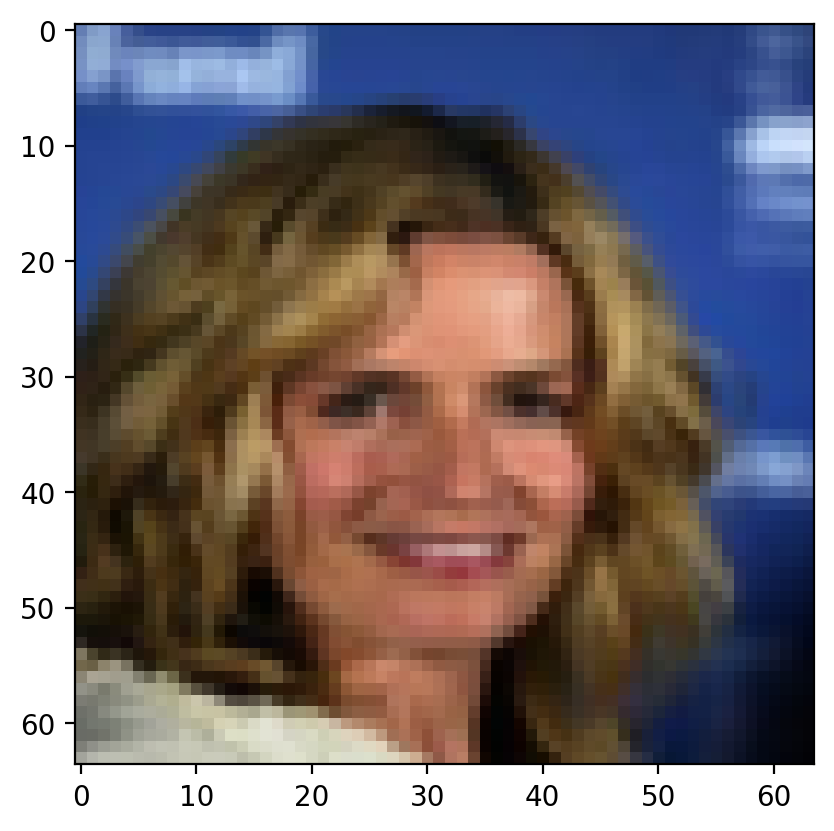

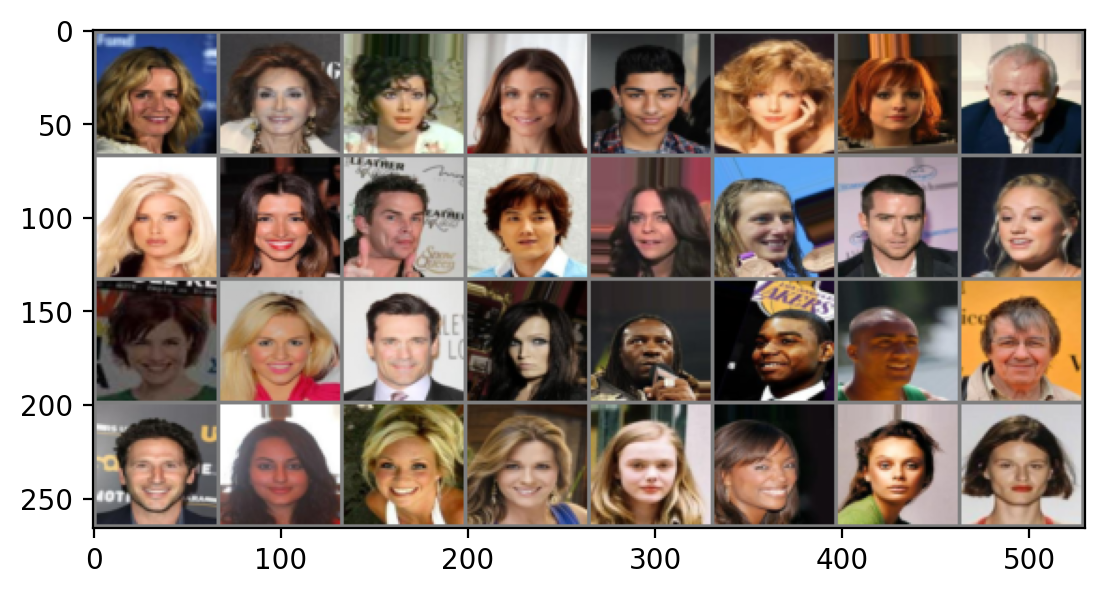

In [7]:
train = iter(trainloader)

i,l = next(train)

imshow(i[0,:,:,:])

imshow(torchvision.utils.make_grid(i))

In [8]:
i.shape

torch.Size([32, 3, 64, 64])

Como vemos, contamos con batches de 32 imágenes asociadas a rostros faciales de celebridades.

## A class to implement the encoder mean and variance

With the following class, we implement the CNN network to obtain both $\mu_\eta(\mathbf{x}), \sigma_\eta(\mathbf{x})$, which determine the moments of the approximate posterior distribution $q(\mathbf{z}|\mathbf{x})$.

We use a single CNN with input $\mathbf{x}$, the output vector of dimension $2k$ is divided in two parts. The first $k$ elements represent the mean, and we compute the variance from the last $k$ elements using a soft-plus.

The actual design of this network is borrowed from [this paper](https://paperswithcode.com/method/beta-vae). It could be improved by adding batch norm layers, but you will see it does perform well already.

> **Exercise**: Complete the following code. What are the spatial dimensions of the 256 feature maps at the ouput of the `conv5` convolutional layer? 

Usaremos una CNN con entrada datos x y su salida se usará de forma que la primera mitad de los datos se usarán para obtener la media y la otra para la varianza. Con esto (y sabiendo que es una normal con dicha media y varianza) podemos obtener la distribución de probabilidad de mi espacio latente "z" dados mis datos del dataset de entrada "x".

In [9]:
class encoder(nn.Module):
    
    def __init__(self,dimz,channels=3,var_x=0.1):
        
        
        super().__init__()
        
        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # self.conv1 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1
        
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, 
                               kernel_size=4, stride=2, padding=1)
        
        self.relu = nn.ReLU()
        
        # self.conv2 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, 
                               kernel_size=4, stride=2, padding=1)

        # self.conv3 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1  
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=4, stride=2, padding=1)      

        # self.conv4 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1  

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, 
                               kernel_size=4, stride=2, padding=1)

        # self.conv5 is a convolutional layer, with 256 output channels, kernel size 4, stride 1,
        # and padding 0                                
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256, 
                               kernel_size=4, stride=1, padding=0) 
        
        self.final_dim = 256 # el resultado final es de 256x1x1 (lo he hecho a mano teniendo en cuenta el padding con N=(W-F+2P)S+1)

        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(self.final_dim, self.dimz*2) # YOUR CODE HERE
        
        self.softplus = nn.Softplus()
        
    def forward(self,x):

        # The forward method to project and image into a 2dimz dimensional vector
        
        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = self.relu(self.conv5(z))
        # Transform z into a 256-dim vector
        z = z.view(-1,256)
        z = self.linear(z)

        return z
    
    def encode_and_sample(self,x,flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method
        
        z = self.forward(x)

        # The mean is the first dimz components of the forward output
        
        mu = z[:,:self.dimz]

        # We compute the variance from the last dimz components using a 
        # soft plus
        var = self.softplus(0.5 * z[:,self.dimz:])
        
        sample = None
        
        if(flag_sample==True):
            
            eps = torch.randn_like(var) 
            
            sample = mu + eps*(var**0.5)
        
        return mu,var,sample
    

Con esta clase, hacemos lo correspondiente al encoder del VAE. (Es decir, la obtención de nuestros datos con una distribución p(z|x)) Con esto reducimos la dimensionalidad de la entrada "x" a un espacio latente "z", el primer valor que sale de la capa lineal hace referencia a la media de la distribución de z y el segundo, a la varianza. Con esto devolvemos, la media, varianza y una muestra de la distribución de probabilidad nacida por el o los datos de entrada "x" en forma del espacio latente reducido "z".

> **Exercise**: Using `dimz=2`, create an encoder object and print the mean `mu_z` and variance `var z` in the z space for one image.

In [11]:
#YOUR CODE HERE

my_encoder = encoder(dimz = 2)
mu_z, var_z, sample = my_encoder.encode_and_sample(i[0])

print('La media obtenida en el espacio z para una sola imagen es de: ' + str(mu_z))
print('La varianza obtenida en el espacio z para una sola imagen es de: ' + str(var_z))

La media obtenida en el espacio z para una sola imagen es de: tensor([[ 0.0557, -0.0121]], grad_fn=<SliceBackward0>)
La varianza obtenida en el espacio z para una sola imagen es de: tensor([[0.6757, 0.7078]], grad_fn=<SoftplusBackward0>)


Buscamos un espacio latente de 2 dimensiones; con ello obtenemos la media y la varianza de "z" dada una sola imágen de entrada. Los dos valores (tanto de media como de varianza) obtenidos, no reflejan un valor optimizado debido a que estamos utilizando el modelo sin entrenar.

## A class to implement the decoder mean

Given a sample from $\mathbf{z}$, we generate images by sample from $p(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})$, where we take $\sigma_x=0.1$ as a reconstruction noise. The following class implements the mean NN $\mu_\theta(\mathbf{z})$ using transpose convolutions. Again, the network design comes from the same [this paper](https://paperswithcode.com/method/beta-vae).

> **Exercise**: complete the following code. Why do we use an hiperbolic tangent output activation?


In [12]:
class decoder(nn.Module):
    
    def __init__(self,dimz,channels=3,var_x=0.1):
        
        super().__init__()

        # We expand z into a 256 dimensional vector 
        
        self.linear = nn.Linear(dimz,256)
        
        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # self.tconv1 is a convolutional layer, with 64 output channels, kernel size 4, stride 1,
        # and padding 0 
        
        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1,padding=0)

        # self.tconv2 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1         
        
        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1  
        
        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1
        
        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with channels output channels, kernel size 4, stride 2,
        # and padding 1        
        
        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2,padding=1)
        
    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        x = self.relu(self.tconv5(x))   
        return x
    
    def decode(self,z):

        # This function simply calls the forward method
        # De esta manera, a nivel de código, llamamos al decodificador como tal que devolverá una imagen de dimx y con una distribución de probabilidad condicionada por la existente en "z".
        
        return self.forward(z)

Se trata del decoder de nuestro VAE (o, lo que es lo mismo la obtención de los datos "x" (que pueden ser nuevos datos sintéticos) nacidos del espacio latente, es decir, p(x|z)). 

> **Exercise:** create a decoder object using again `dimz=2`. Given the mean projection of an image `mu_z` that you obtained before, use the decoder to obtain the mean `x_mean` of $p(\mathbf{x}|\mathbf{z})$. Represent one original image versus the reconstruction. Obviously, since you have not trained the model yet, do expect too much.

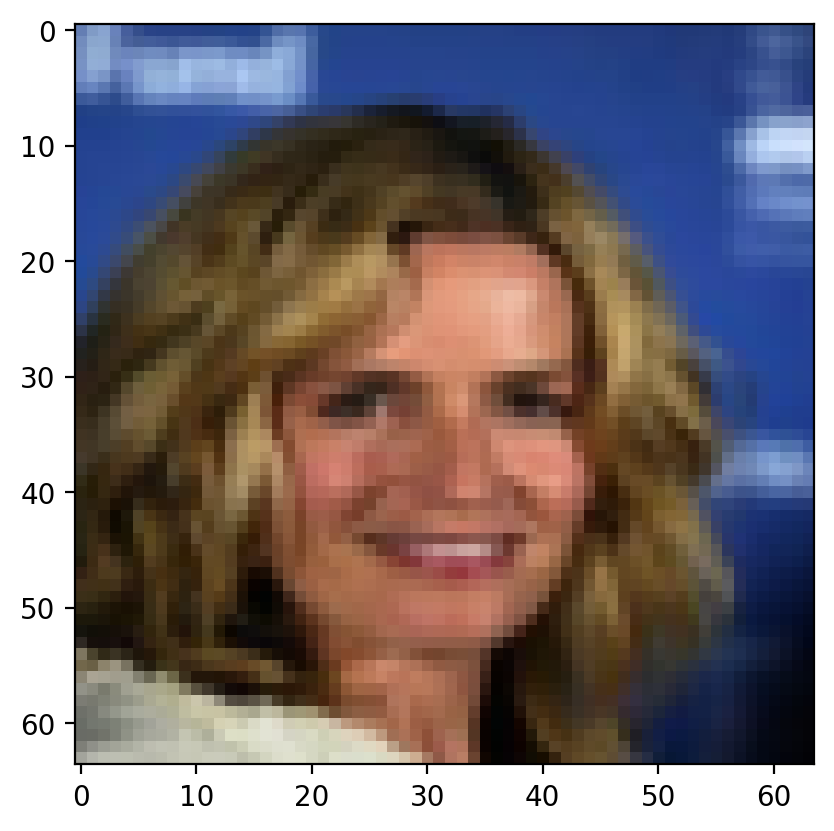

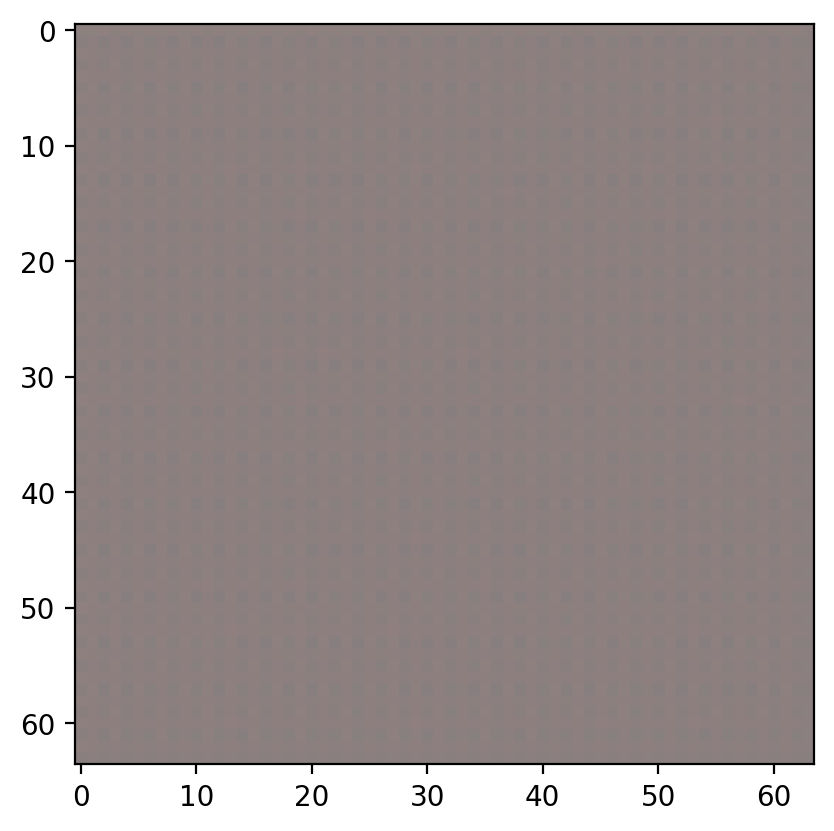

In [13]:
# Reducimos a un espacio latente de 2 dimensiones solamente y reconstruimos la imágen parar compararla con la original

my_dec = decoder(dimz=2)

x_mean = my_dec.decode(mu_z).detach()

imshow(i[0,:,:,:])

imshow(x_mean[0,:,:,:])

Lógicamente, como el modelo no ha sido entrenado, la media "x" (de p(x|z)) obtenida con la decodificación del valor plasmado en "z" difiere mucho de la original. Aún debemos entrenar el modelo para obtener un p(x|z) realista.
Con la siguiente función entrenaremos el valor de la media (y no el de la varianza ya que, recordemos, es una constante equivalente a 0.1).

A su vez, fuera de que esté entrenado o no, reducir mi modelo a un espacio latente de 2 dimensiones y reconstruirlo a la perfección es una tarea arduamente compleja.

Observe that, since the mean `x_mean` is so different from the real image, then the real image is **extremely unlikely** in the distribution $p(\mathbf{x}|\mathbf{z})$. The model will never generate it by sampling. 

For one image `x`, the following function evaluates the log-likelihood of an independent Gaussian distribution given the mean and the diagonal covariance matrix. In the function, both `x` and `mu_x` are passed as images and internally stacked to vectors. `var_x` is a constant. Recall that `var_x` is a constant vector of 0.1 elements.



In [14]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))
    
    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

> **Exercise:** Compute the log-likelihood of one real image given `x_mean` computed above and `var_x=0.1`.

tensor(-611855.8750)


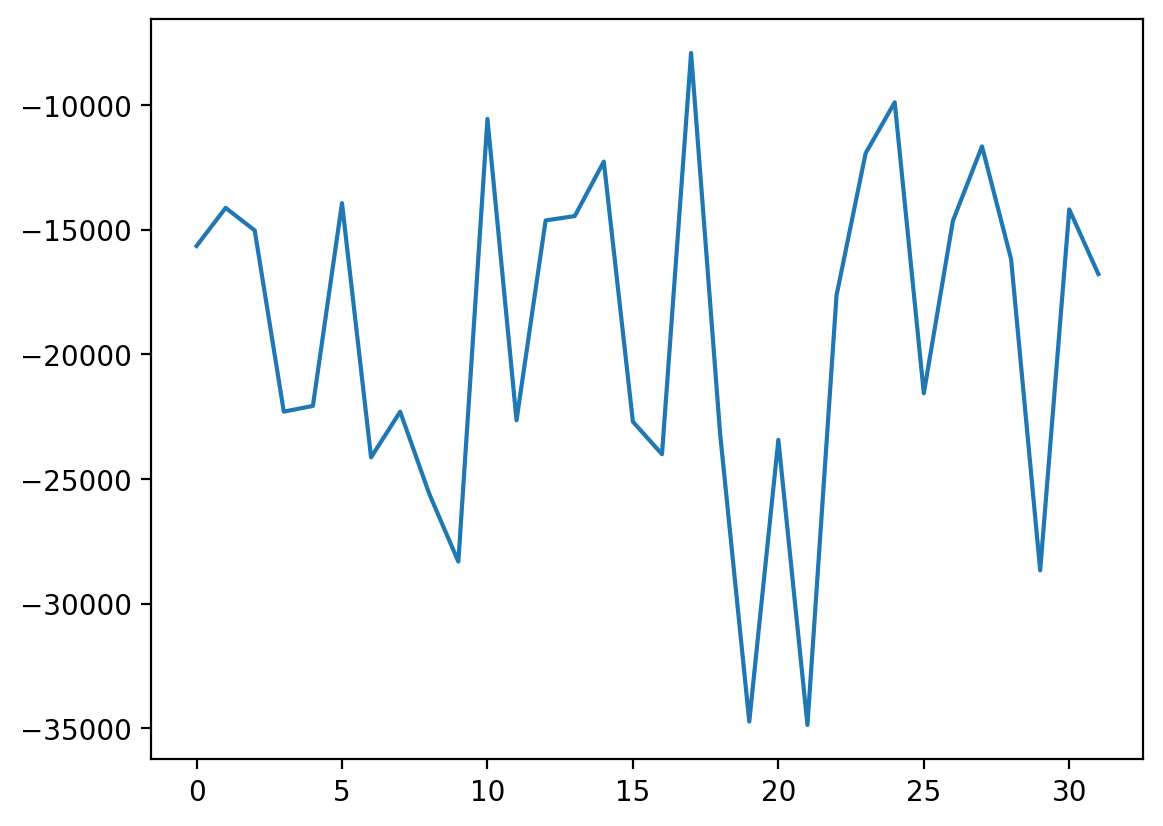

In [15]:
var_x = 0.1

logp,logp_data = eval_Gaussian_LL(i,x_mean,var_x)

print(logp)

plt.plot(np.arange(0,32),logp_data)

Observamos la fluctuaciones en el resultado del "log-likelihood" nacida de introducir una imágen con su reconstrucción. Ese resultado da indicios de aleatoriedad los cuales tienen sentido teniendo en cuenta que el modelo aun no ha sido entrenado y la reconstrucción de la señal tendrá componentes estocásticas.

## The variational autoencoder class

The following class puts together the VAE encoder & decoder and also defines the ELBO lower bound. We will extend it later to incorporate training methods.

> **Exercise**: complete the following code. 

In [16]:
class VAE(nn.Module):
    
    def __init__(self,dimz,channels=3,var_x=0.1):
        
        super().__init__()
        
        self.var_x = var_x
        
        self.dimz = dimz

        # We create an encoder network
        
        self.encoder = encoder(dimz = self.dimz, channels=3,var_x=0.1)

        # We create a decoder network
        
        self.decoder = decoder(dimz = self.dimz, channels=3,var_x=0.1)
        
    def forward(self,x):

        # In the forward method, we return the mean and variance 
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the 
        # encoder's posterior distribution.
        
        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x)
        
        # Decoder provides the mean of the reconstruction
        
        mu_x = self.decoder.decode(sample_z) 
        
        return mu_x,mu_z,var_z
    
    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp,_ = eval_Gaussian_LL(x,mu_x,var_x = 0.1)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz  
    

        

Construimos el VAE al completo. Indicamos la dimensión que queremos que tenga el espacio latente, codificamos (obteniendo (p(z|x)) y decodificamos (obteniendo(p(x|z)))). Tras el forward devoldemos mu_z,var_z (del espacio latente codificado) y mu_x (del espacio decodificado ; asumimos, como hemos dicho antes, que var_x = 0.1).

Finalk

> **Exercise:** Create a VAE object for `dimz=2` and evaluate the ELBO using `mu_z`, `var_z`, and `x_mean` computed above.

In [17]:
my_vae = VAE(dimz = 2)

x_mean, mu_z, var_z = my_vae.forward(i)

print(my_vae.loss_function(i,x_mean,mu_z,var_z))


(tensor(670183.6875, grad_fn=<AddBackward0>), tensor(670181.6875, grad_fn=<NegBackward0>), tensor(2.0279, grad_fn=<MulBackward0>))


## Incorporating a training method

The following class completes the implementation of the VAE. **You do not have to edit anything**, but it is highly recommended to go through the code. It is actually very similar to the training classes we have been implementing. Only three points to remark:


- Since training is pretty slow (every epoch can take a few minutes), we save the model every few minibatches. User indicates the saving path using the `save_folder` argument.
- I have introduced a `restore` flag. When set it to true, we load the model parameters from a file saved in the `save_folder` argument.
- The class also incorporates a method to sample from the generative model. Namely, create new images. To this end, we sample $\mathbf{z}$ from $p(\mathbf{z}) = \mathcal{N}(0,I)$ and then we return the mean of $p(\mathbf{x}|\mathbf{z})$.

In [18]:
class VAE_extended(VAE):

    def __init__(self, dimz=2,  channels=3, var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):
        
        super().__init__(dimz,channels=3,var_x=0.1)

        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        self.save_folder = save_folder

        if(restore==True):
            #state_dict = torch.load(self.save_folder+'VAE_checkpoint.pth')
            #self.load_state_dict(state_dict)
            self.load_state_dict(torch.load(self.save_folder+'VAE_checkpoint.pth', map_location=torch.device('cpu')))

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for images, labels in trainloader:

                images = images.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(images)

                loss, rec, kl_l = self.loss_function(images,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item() 

                self.optim.step()

                if(idx_batch%10==0):

                    torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')

                idx_batch += 1

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()    

Extendemos VAE para añadirle un método de entrenamiento. De normal entrenaremos unas solas épocas o usaremos un modelo pre-entrenado ya que el entrenamiento como tal es muy lento. 
Definimnos también una función sample donde, dado un modelo entrenado, le podemos pedir imágenes nuevas muestreando las distribuciones de probabilidad del espacio latente.

# Validate a pre-trained model

First, we're going to see a VAE model in action. In the file `VAE_checkpoint.pth` linked in Aula Global, I give you the parameters of a VAE with `dim_z=50` trained for 200 epochs with `var_x=0.1`, `lr=1e-3`.

> **Exercise**: Create a VAE with the parameters contained in the file `VAE_checkpoint.pth`. To do so, instantiate the class `VAE_extended` with the `restore_flag` set to `True`.

Veremos la calidad de un modelo pre-entrenado con un espacio latente de 50.

In [19]:
path_to_save = 'C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Aprendizaje Profundo/Practica1/'
my_vae = VAE_extended(dimz = 50, save_folder=path_to_save,restore=True)

> **Exercise:** Using the method `sample` from the clase `VAE_extended`, generate 20 images from the probabilistic model. **Note these are images created by our model! They correspond to people that do not exist!**.

There are many variants of VAEs that quite improve these results, but even this vanilla VAE we have implemented does a pretty god job! Despite the images contain lots of artifacts, note that the images contain lots of very realistic details. Also note how the model tries to vary the features of the images (hair, background, smiles etc ...). 

In [20]:
# Dado el modelo pre-entrenado, generamos 20 nuevas imágenes de la distribución del espacio latente.

x = my_vae.sample(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


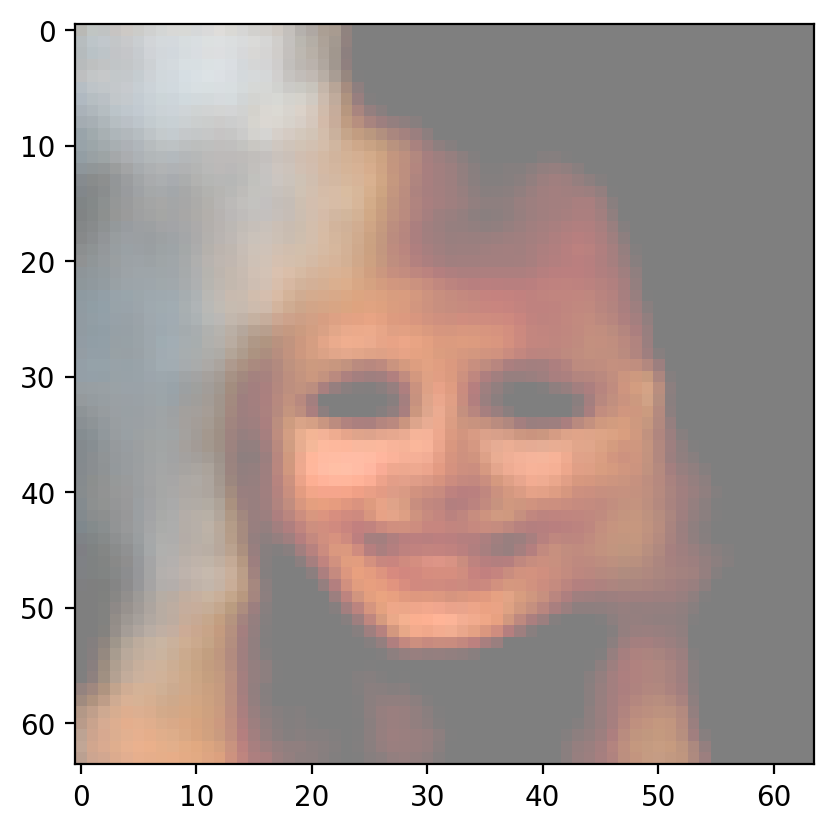

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


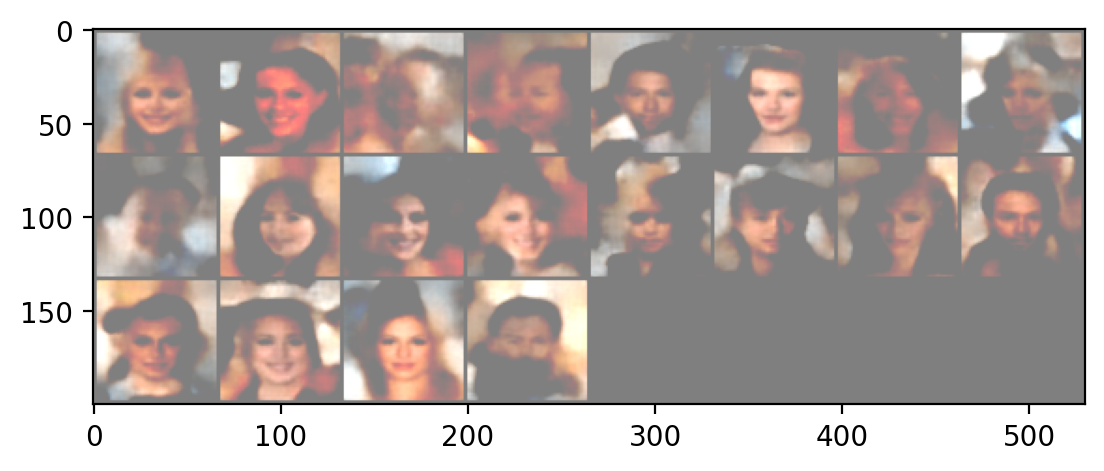

In [21]:
# Las mostramos

imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))

Como vemos, si bien tienen algunos artefactos, los rostros y los detalles son bastante realistas. Esto es gracias a la continuidad nacida en el espacio latente al generar un modelo probabilístico.

> **Exercise:** Compare a real image versus its reconstruction. Note that the model is by default save in a GPU if available, so you have to move the images there. To visualize reconstructed images, you have to move the result of the decoder back to CPU.

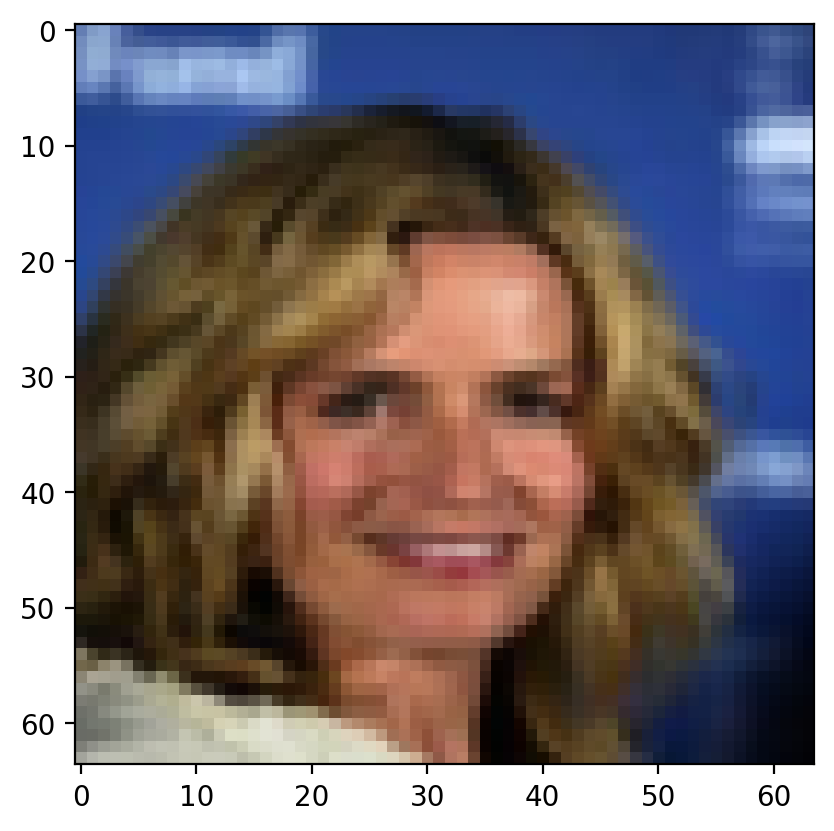

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


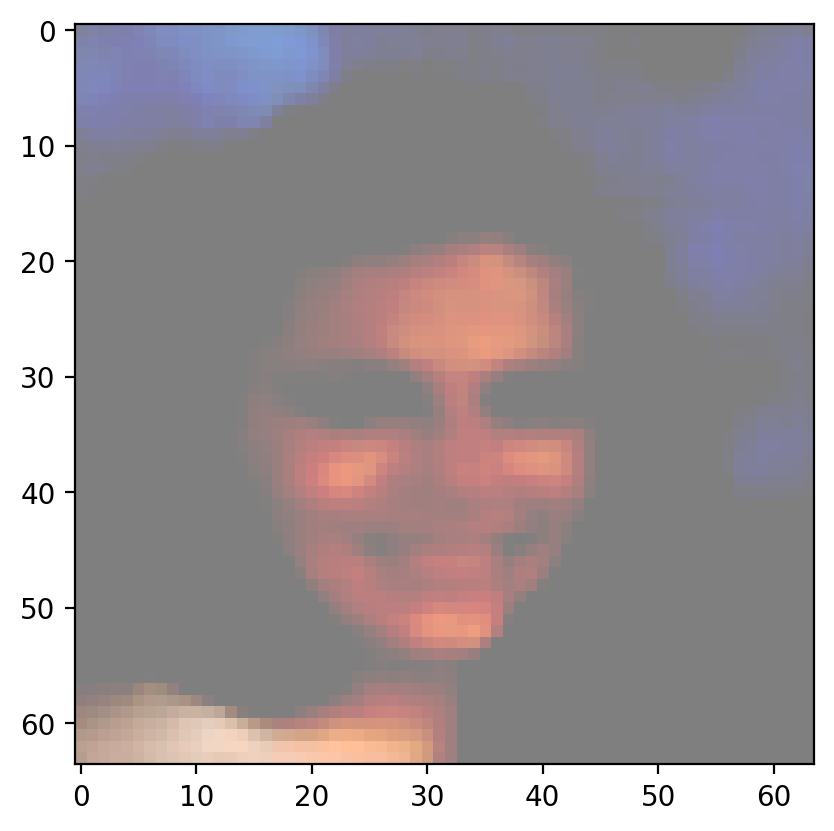

In [28]:
# Imagen 0 real vs reconstruida

z_batch,_,_ = my_vae.encoder.encode_and_sample(i)

x_reconstructed = my_vae.decoder.decode(z_batch).detach() 

# We plot he original image
imshow(i[0,:,:,:])

# And the reconstruction

imshow(x_reconstructed[0,:,:,:])


Dado el modelo pre-entrenado, vemos una imagen con detalles realmente buenos y realistas así como un "shape" general aceptable.

> Using the VAE, we can also *interpolate* between images. Namely, given the latent representation $\mathbf{z}_1$ and $\mathbf{z}_2$ of two images, we can visualize the images that correspond to different linear interpolations between both latent points. To this end, given $w=[0,0.1,0.2, ...,1]$, will visualize the mean of $p(\mathbf{x}|\mathbf{z})$ for 

$$z = (1-w)\mathbf{z}_1+w\mathbf{z}_2$$

**Exercise:** Complete the following code to interpolate between two images

Gracias al VAE podemos generar datos sintéticos interpolando entre las distribuciones de probabilidad en "z" de dos imágenes reales. Hagamoslo para las imágenes "0" y "1".

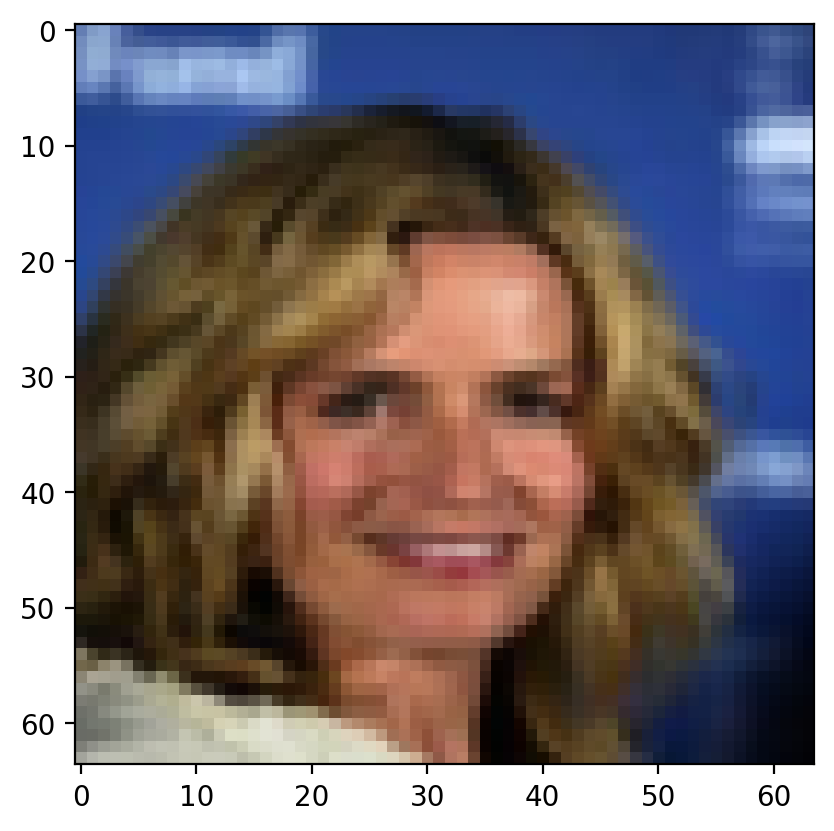

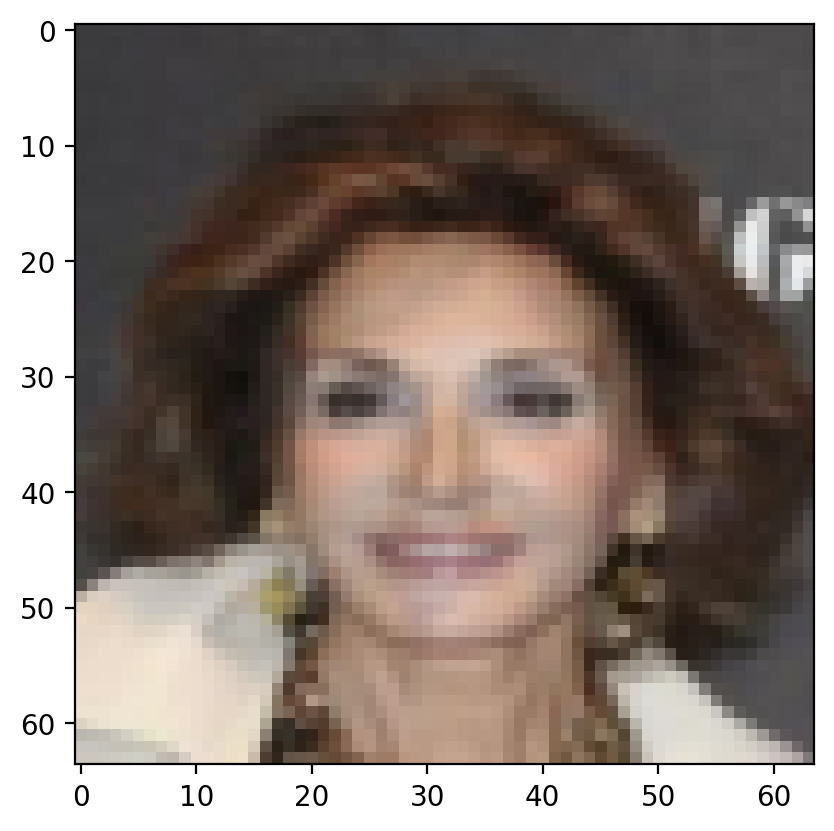

In [26]:
# Lets visualize the images to interpolate

img_1 = i[0,:,:,:]  
img_2 = i[1,:,:,:]

imshow(img_1)

imshow(img_2)


In [31]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0] # media en las 50-dim de la imágen 0
z_2 = z_batch[1] # media en las 50-dim de la imágen 1

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [my_vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

In [36]:
# Hemos obtenido 10 imágenes (1 por cada valor le hemos dado a w a la hora de crearlas mezclando z_1 y z_2)

len(reconstructed_image)

10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


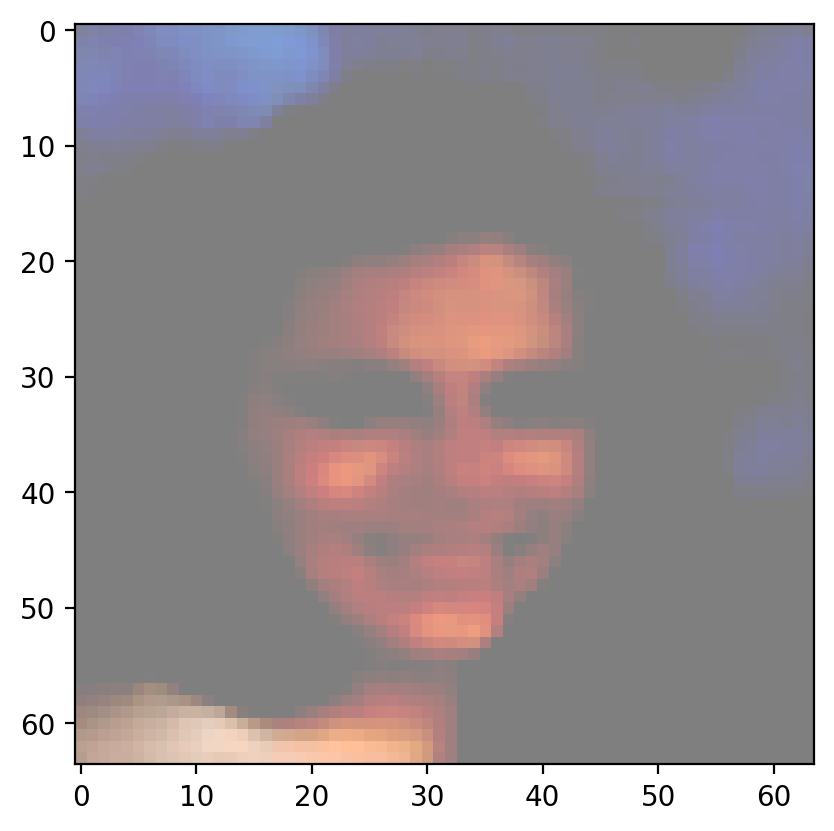

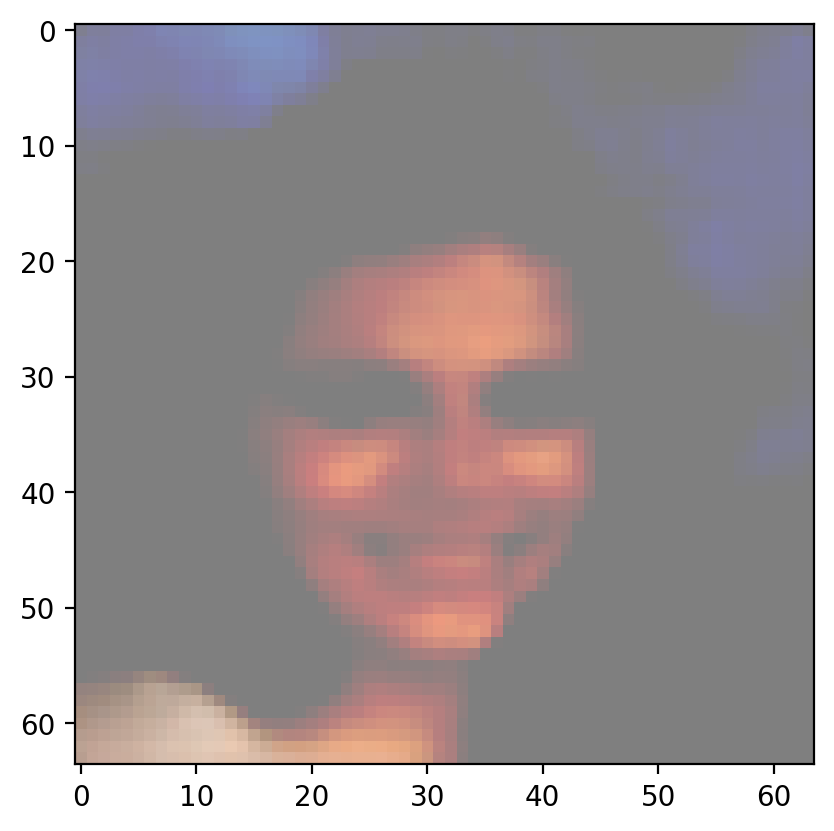

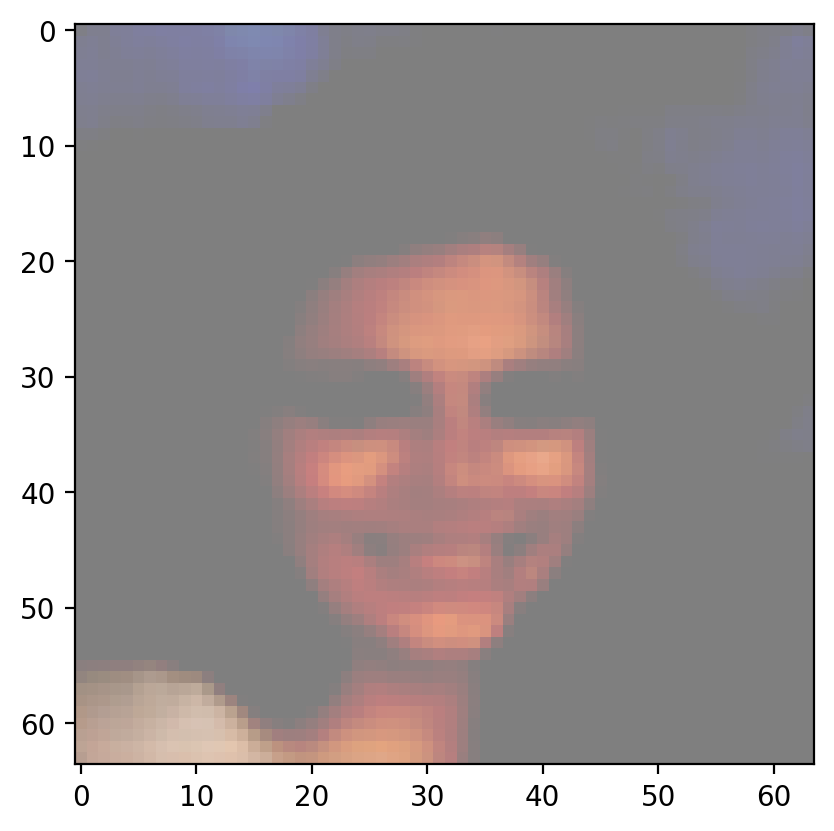

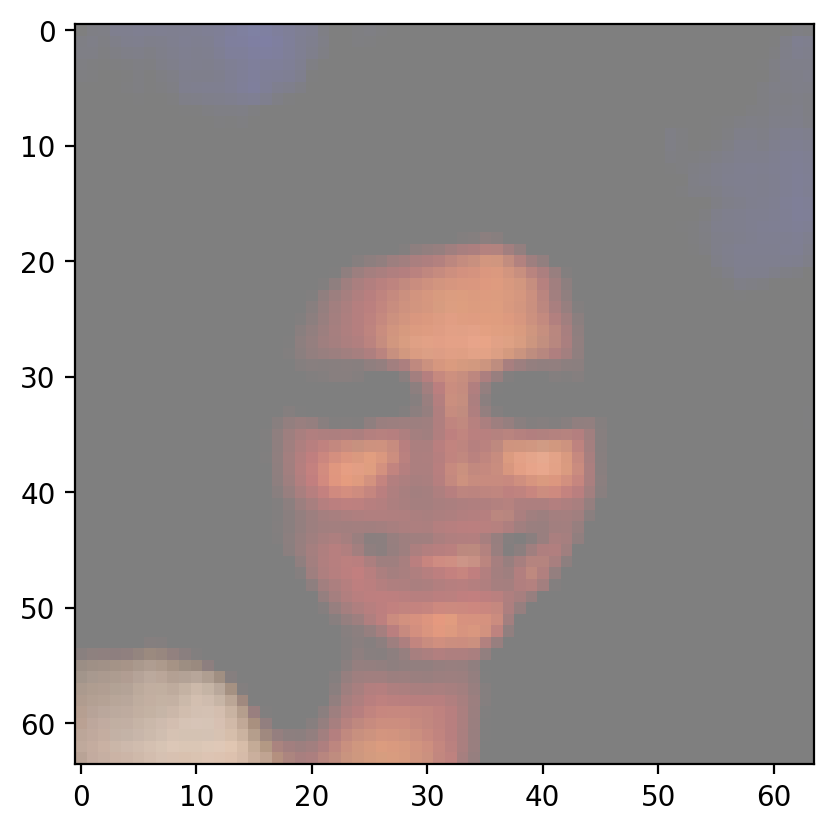

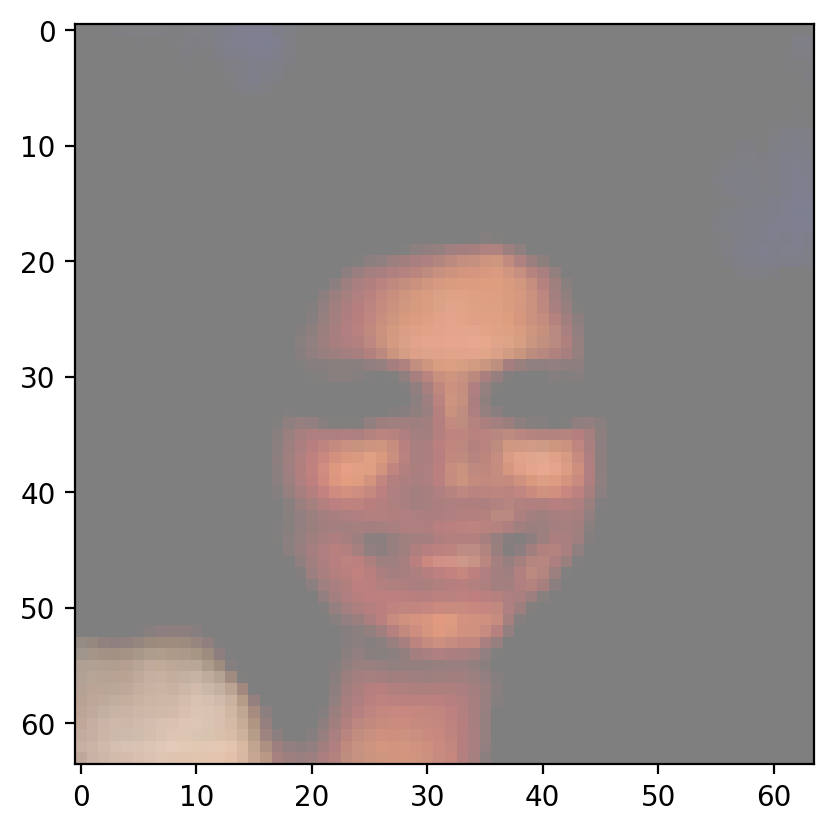

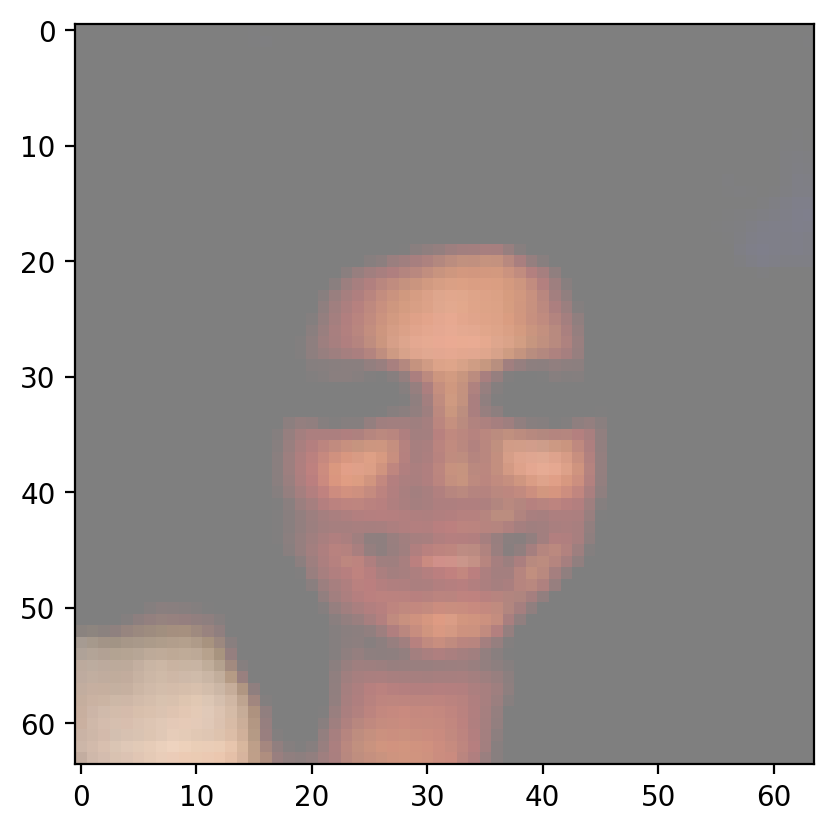

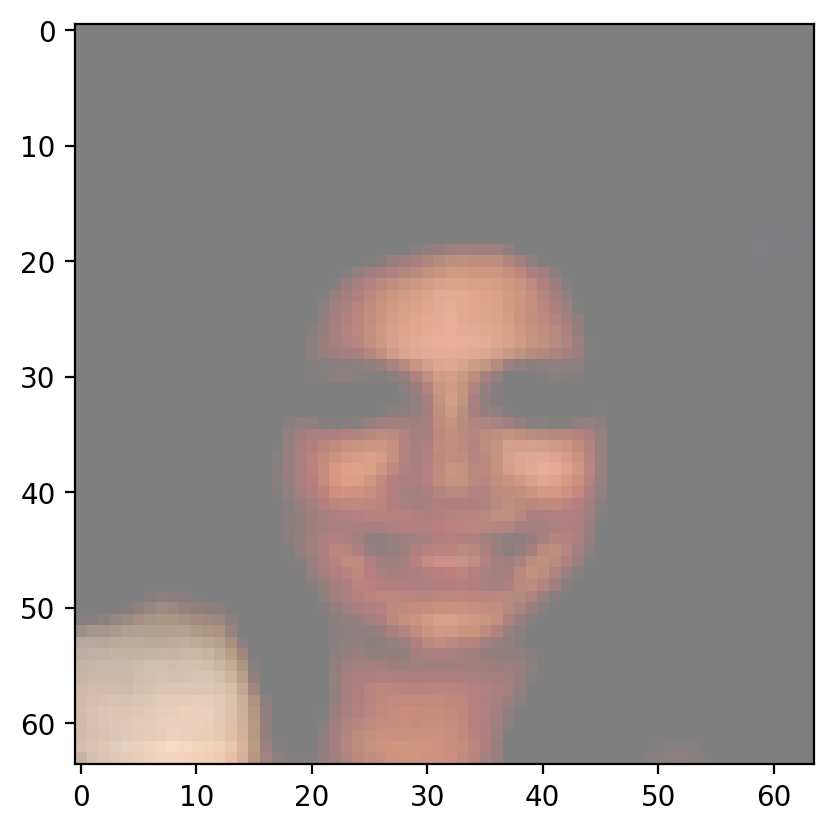

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


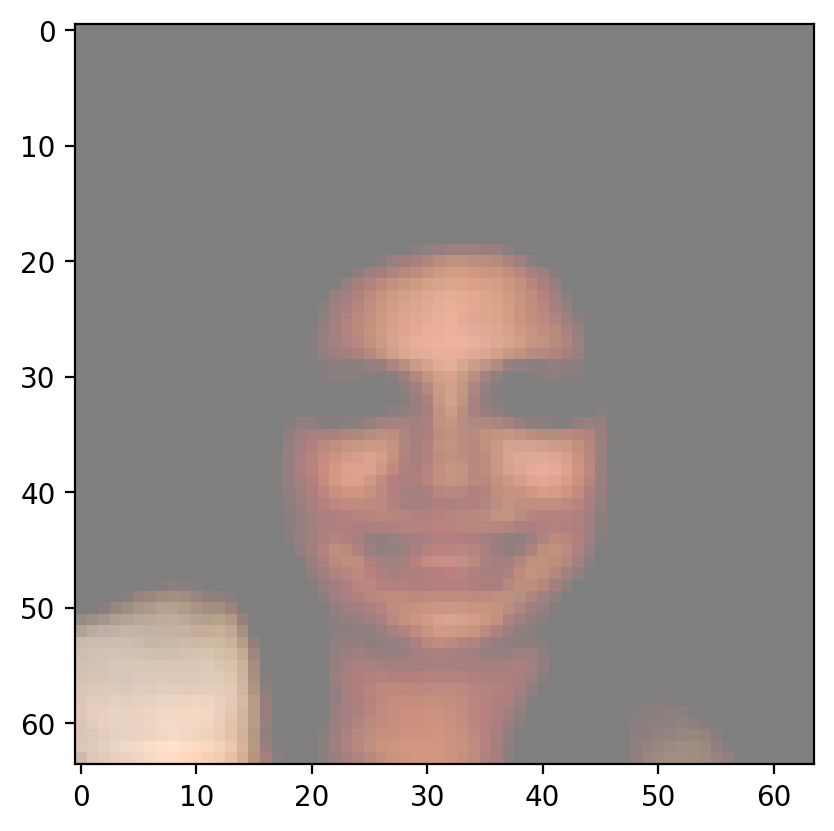

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


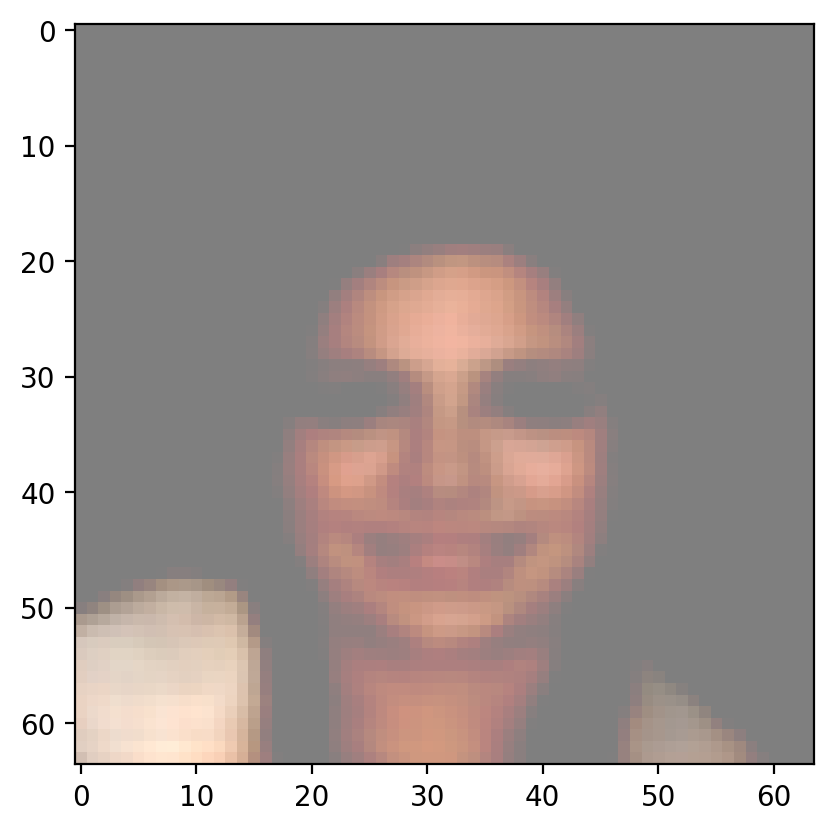

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


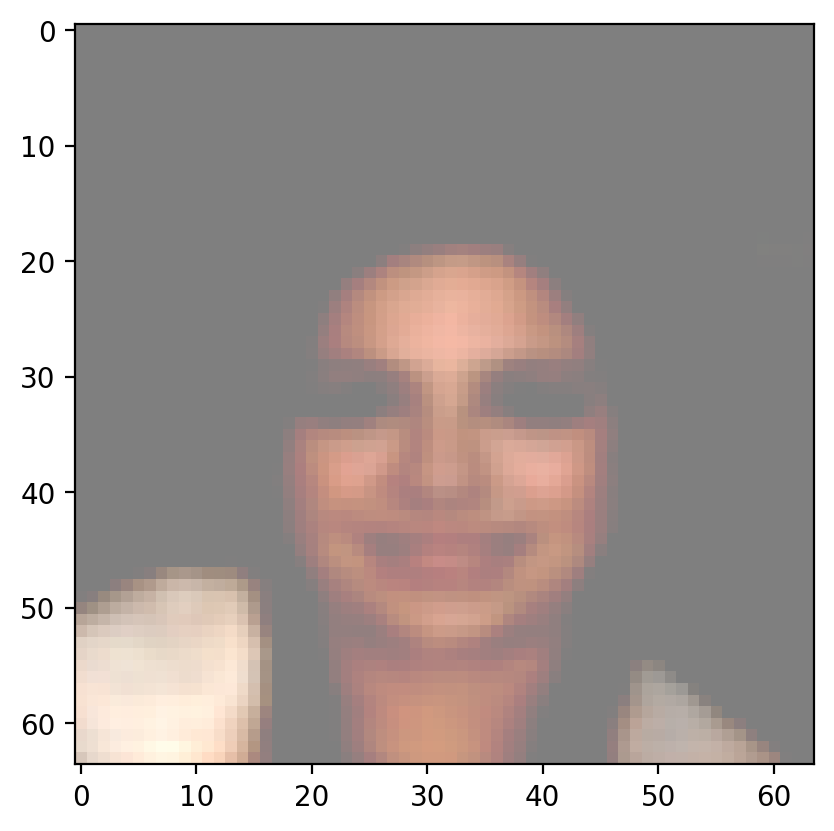

In [37]:
# Visualize all images in the reconstructed_image list

for im in reconstructed_image:
  imshow(im[0,:,:,:])

Vemos como, a medida que aumenta "w" z_2 va tomando más importancia y por tanto, la imagen híbrida de z_1 y z_2 pasa de parecerse más a z_1 a z_2. Salen 10 rostros completamente nuevos y con buena calidad de detalle.

>**Exercise:** Using TSNE over `z_batch``, show how real images are projected in a 2D space. The following function is handy (it was already used in the previous lab)

In [38]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def rescale(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))
 
def plot_latent_space_with_images(images,latent,xmin=-150,xmax=150,ymin=-150,ymax=150):
 
    # images --> Minibatch of images (numpy array!)
    # latent --> Matrix of 2D representations (numpy array!)
 
    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

In [41]:
from sklearn.manifold import TSNE

# Apply TSNE over z_batch

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.detach().numpy())

d:\anaconda\envs\ids\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda\envs\ids\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


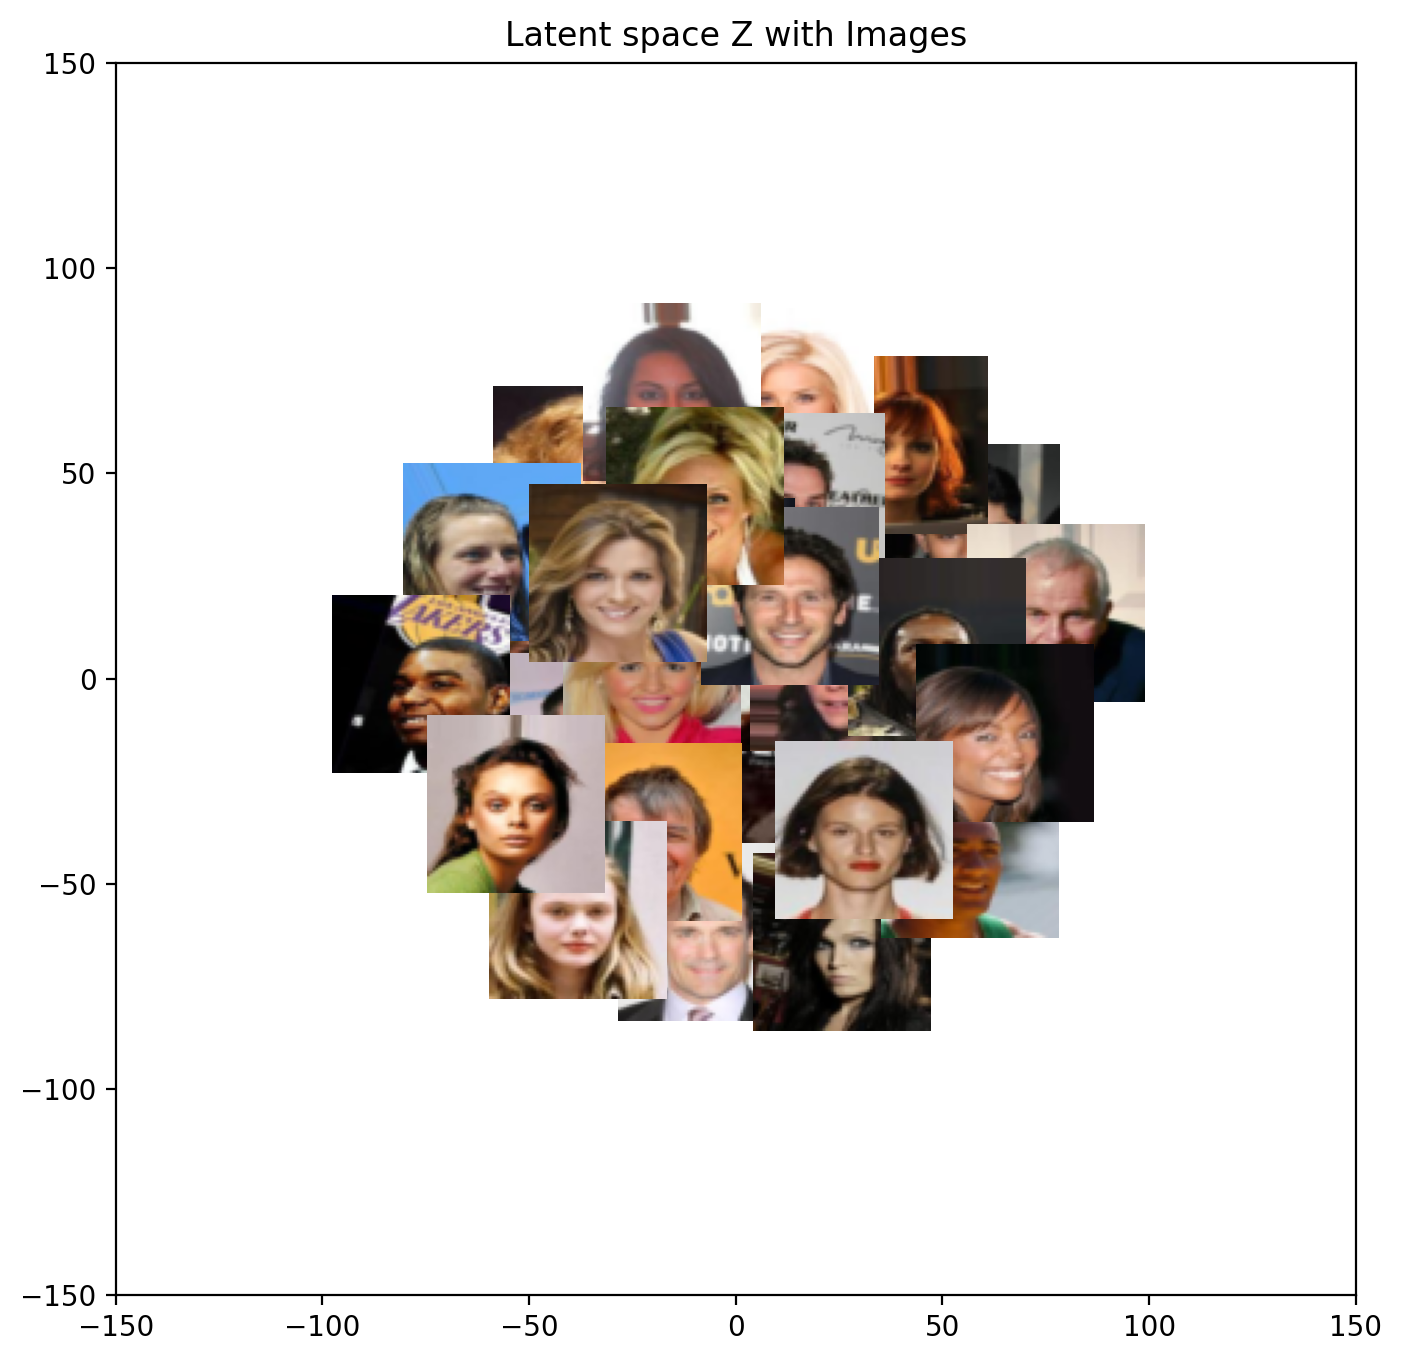

In [42]:
plot_latent_space_with_images(i, latent_tsne)

Ploteamos las imágenes del espacio latente en 2 dimensiones y vemos como se distribuyen en función de las características que las definen y su apariencia.

## Train the VAE from scratch

Just to finish, train your own VAE from zero for a few epochs and generate images from the model. 

Creamos un VAE desde 0 y lo entrenamos por 20 épocas.

In [43]:
#YOUR CODE HERE
my_vae_scratch = VAE_extended(dimz=50, channels=3, var_x=0.1,lr=1e-3,epochs=20)

In [47]:
my_vae_scratch.trainloop(trainloader = trainloader)

Train Epoch: 0 	Loss: 544232.385477
Train Epoch: 1 	Loss: 484825.569003
Train Epoch: 2 	Loss: 475496.764361
Train Epoch: 3 	Loss: 470618.002619
Train Epoch: 4 	Loss: 467070.220918
Train Epoch: 5 	Loss: 464010.314668
Train Epoch: 6 	Loss: 460589.276824
Train Epoch: 7 	Loss: 452447.669527
Train Epoch: 8 	Loss: 442820.518605
Train Epoch: 9 	Loss: 441520.972272
Train Epoch: 10 	Loss: 440230.215137
Train Epoch: 11 	Loss: 439485.569093
Train Epoch: 12 	Loss: 438713.360007
Train Epoch: 13 	Loss: 437740.097363
Train Epoch: 14 	Loss: 436959.331467
Train Epoch: 15 	Loss: 436312.565300
Train Epoch: 16 	Loss: 427673.143605
Train Epoch: 17 	Loss: 419438.156973
Train Epoch: 18 	Loss: 419000.927113
Train Epoch: 19 	Loss: 418455.008941


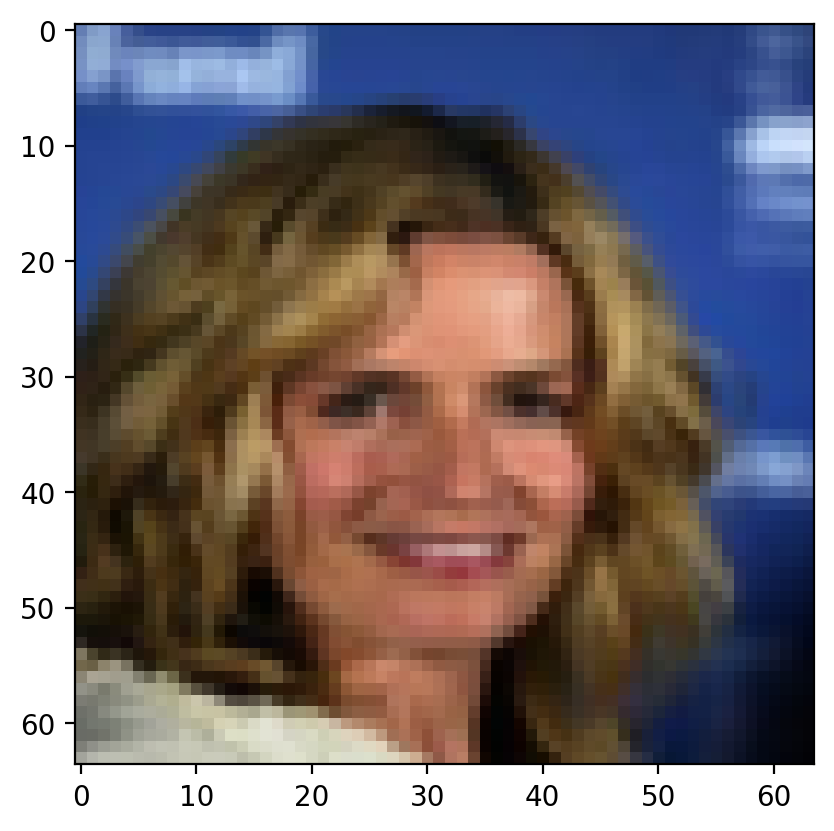

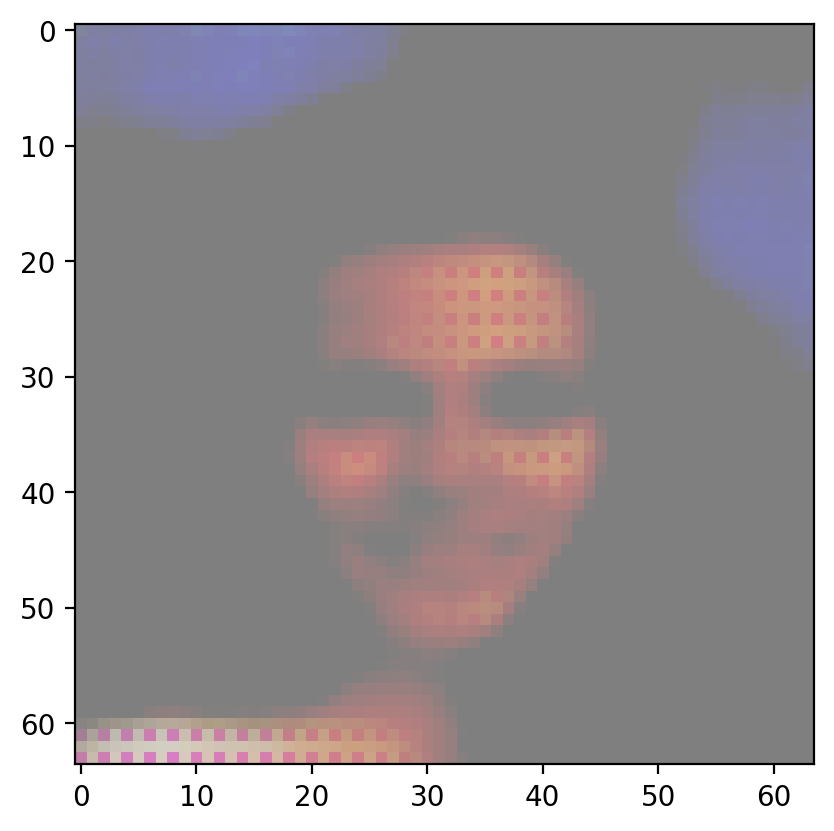

In [48]:
z_batch,_,_ = my_vae_scratch.encoder.encode_and_sample(i)

x_reconstructed = my_vae_scratch.decoder.decode(z_batch).detach() 

# We plot he original image
imshow(i[0,:,:,:])

# And the reconstruction

imshow(x_reconstructed[0,:,:,:])

Lógicamente la loss es alta pues, la imagen difiere objetivamente mucho de la real, sin embargo, en solo 20 épocas conseguimos una reconstrucción bastante aceptable de la imágen original desde el espacio latente.

Veamos su capacidad de construir imágenes híbridas

In [49]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0]
z_2 = z_batch[1]

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [my_vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

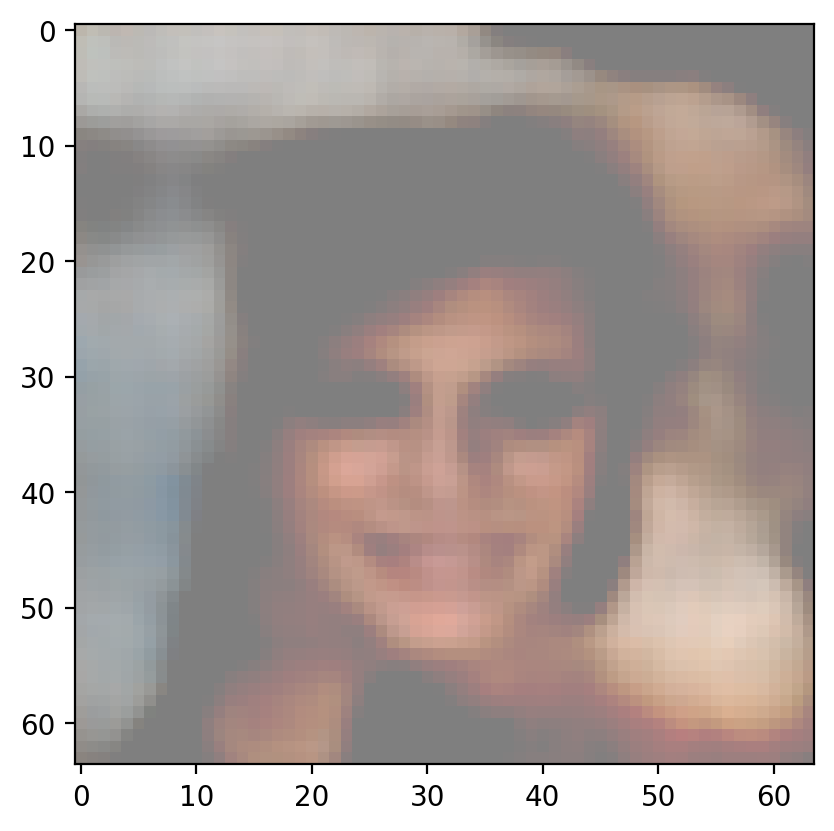

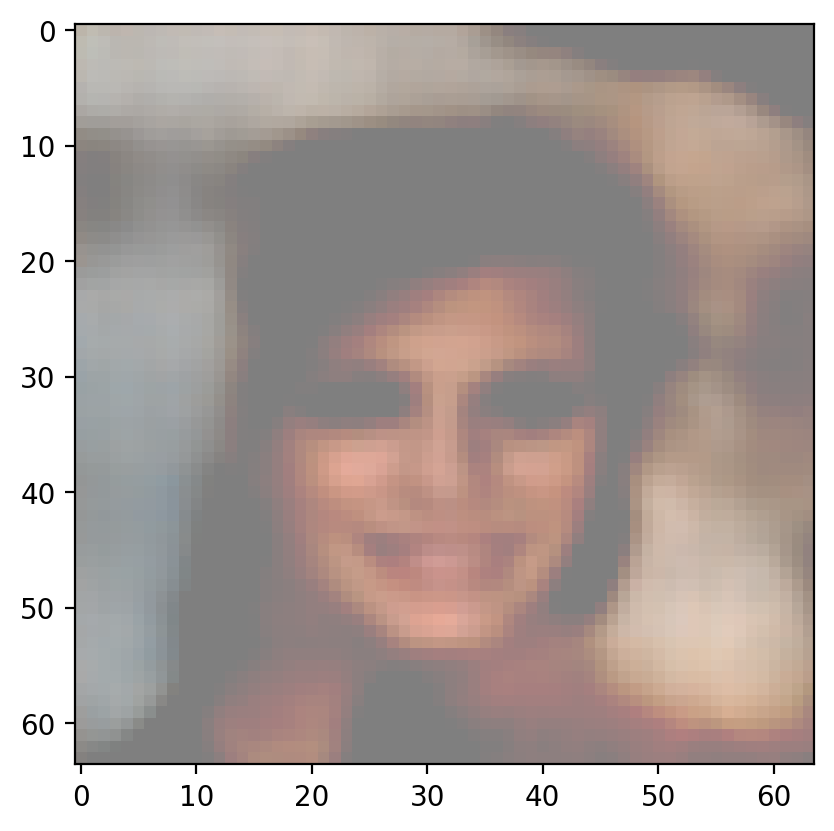

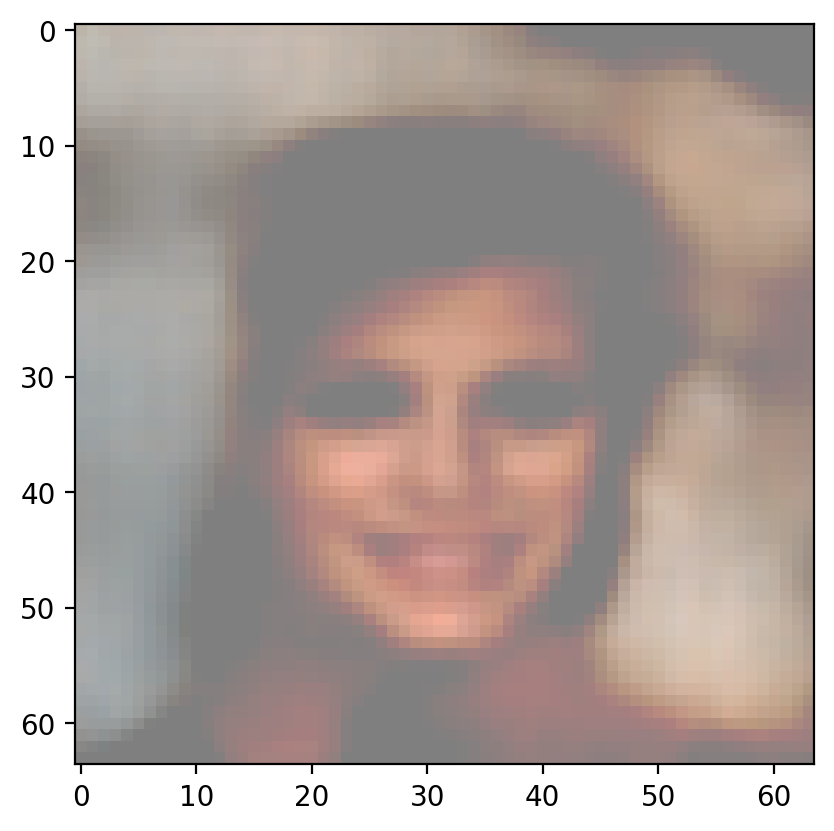

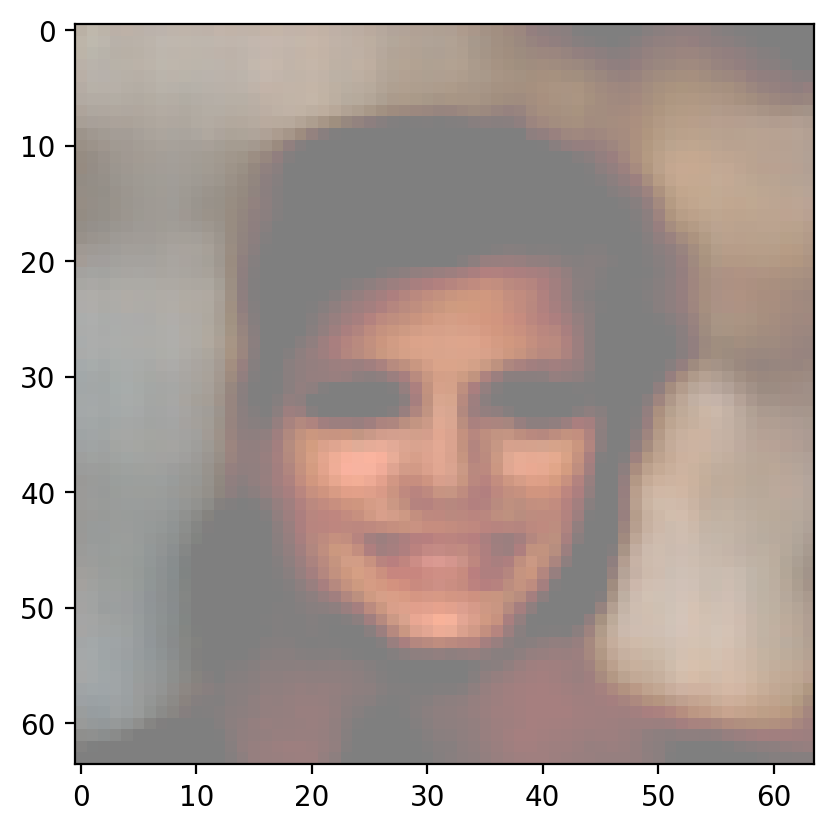

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


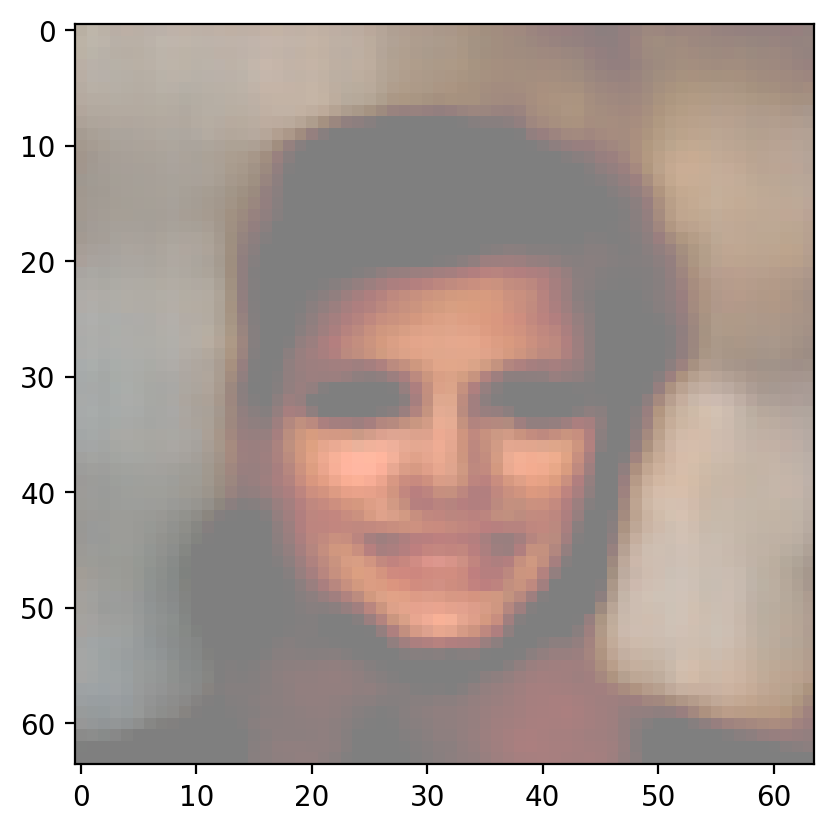

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


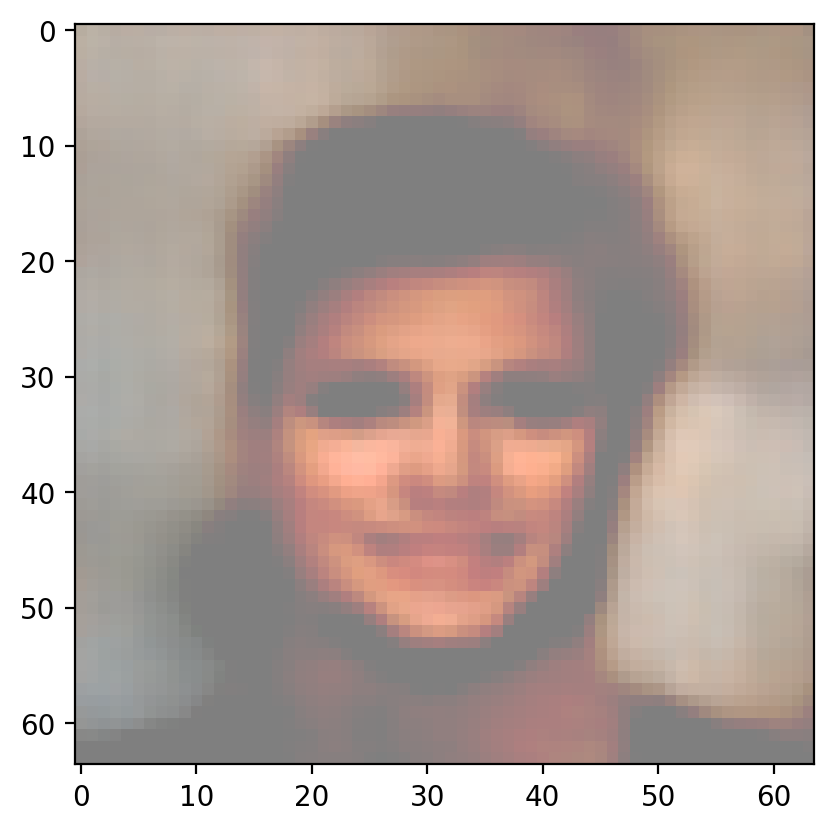

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


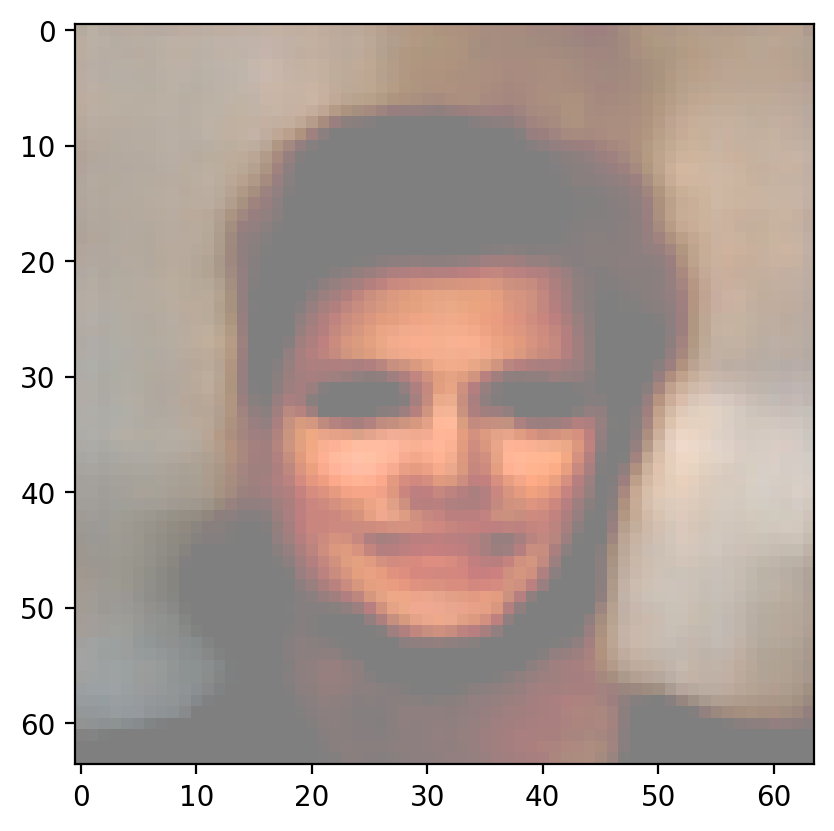

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


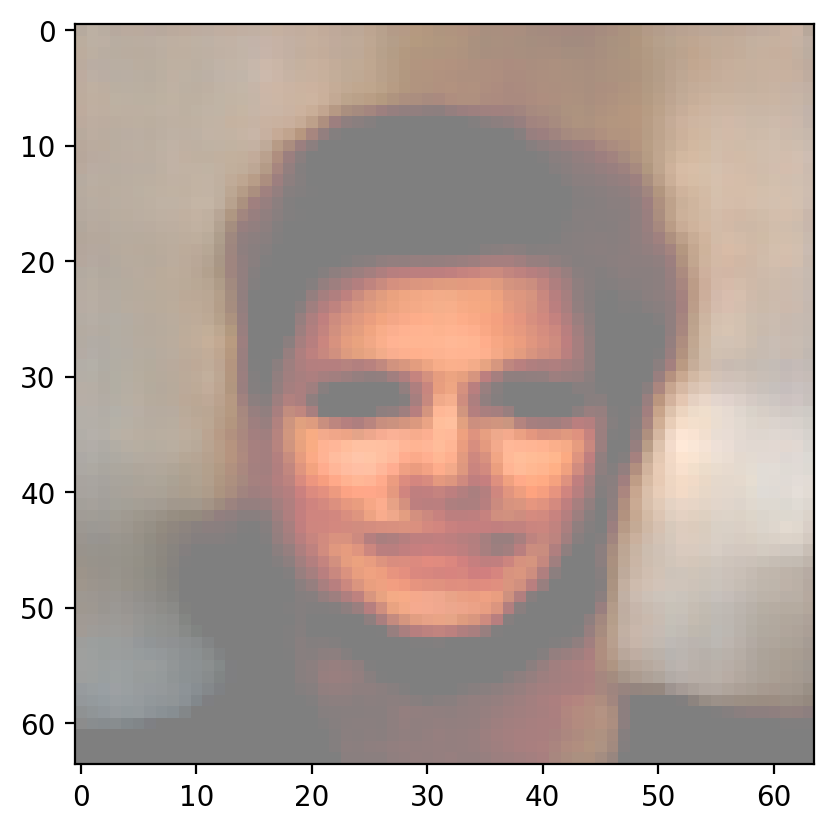

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


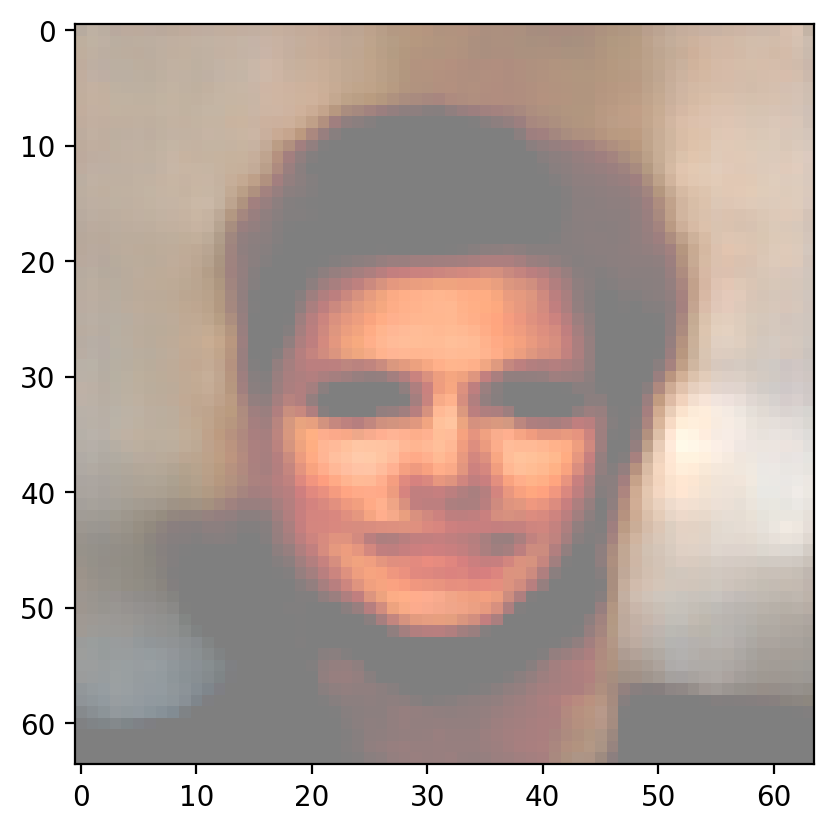

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


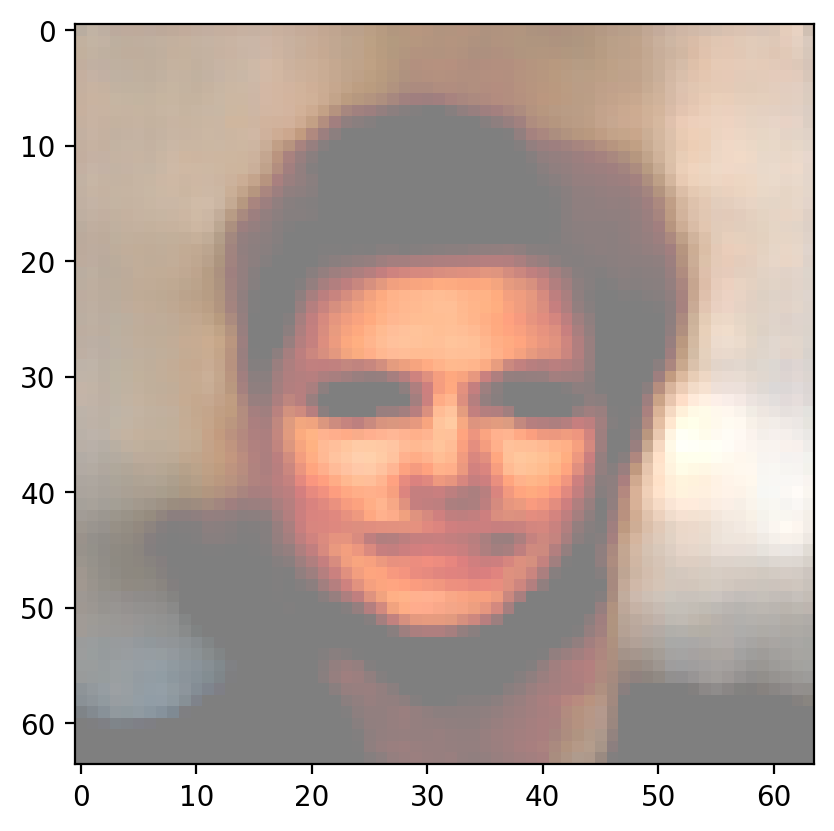

In [50]:
for im in reconstructed_image:
  imshow(im[0,:,:,:])

En solo 20 épocas genera rostros faciales híbridos que, si bien les falta calidad en detalle (definición), son realmente buenos en figura y forma.

Creemos otra VAE desde 0 pero con 100 épocas para ver la mejora

Train Epoch: 0 	Loss: 507762.714686
Train Epoch: 1 	Loss: 456740.849259
Train Epoch: 2 	Loss: 446228.032605
Train Epoch: 3 	Loss: 441426.592847
Train Epoch: 4 	Loss: 438030.672598
Train Epoch: 5 	Loss: 434897.714053
Train Epoch: 6 	Loss: 431019.005509
Train Epoch: 7 	Loss: 429487.877980
Train Epoch: 8 	Loss: 427448.529579
Train Epoch: 9 	Loss: 426032.350885
Train Epoch: 10 	Loss: 425243.895954
Train Epoch: 11 	Loss: 424125.062139
Train Epoch: 12 	Loss: 423362.238801
Train Epoch: 13 	Loss: 422343.818100
Train Epoch: 14 	Loss: 421716.957776
Train Epoch: 15 	Loss: 420936.053197
Train Epoch: 16 	Loss: 420361.591040
Train Epoch: 17 	Loss: 419745.507225
Train Epoch: 18 	Loss: 419468.226201
Train Epoch: 19 	Loss: 419072.152366
Train Epoch: 20 	Loss: 418401.909140
Train Epoch: 21 	Loss: 417893.628342
Train Epoch: 22 	Loss: 417864.208454
Train Epoch: 23 	Loss: 417635.413656
Train Epoch: 24 	Loss: 417262.581738
Train Epoch: 25 	Loss: 416895.170430
Train Epoch: 26 	Loss: 416680.007406
Train Epoch

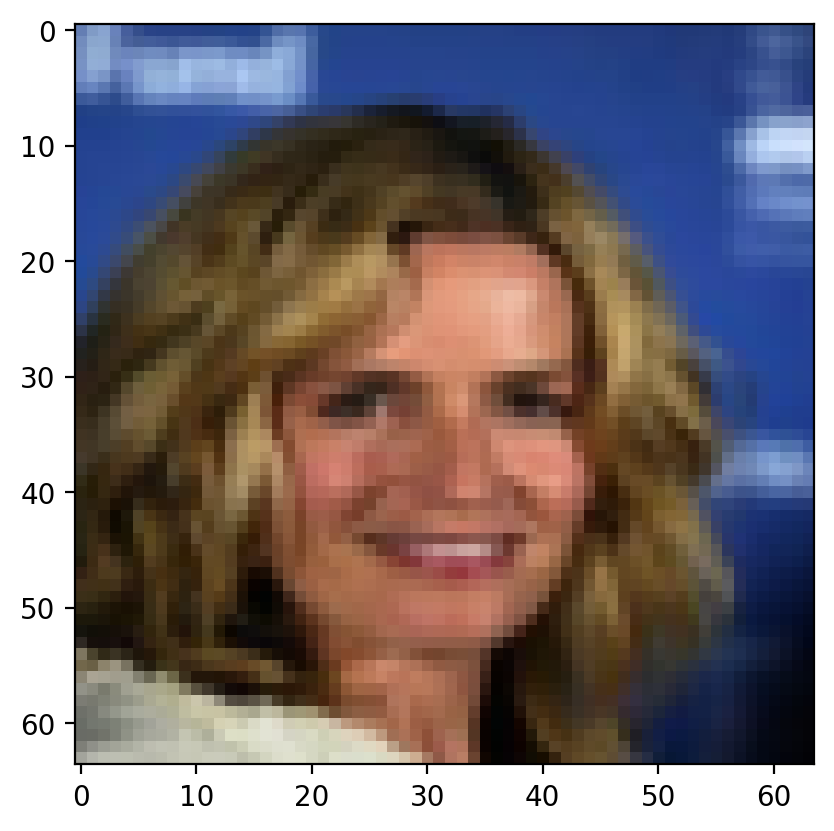

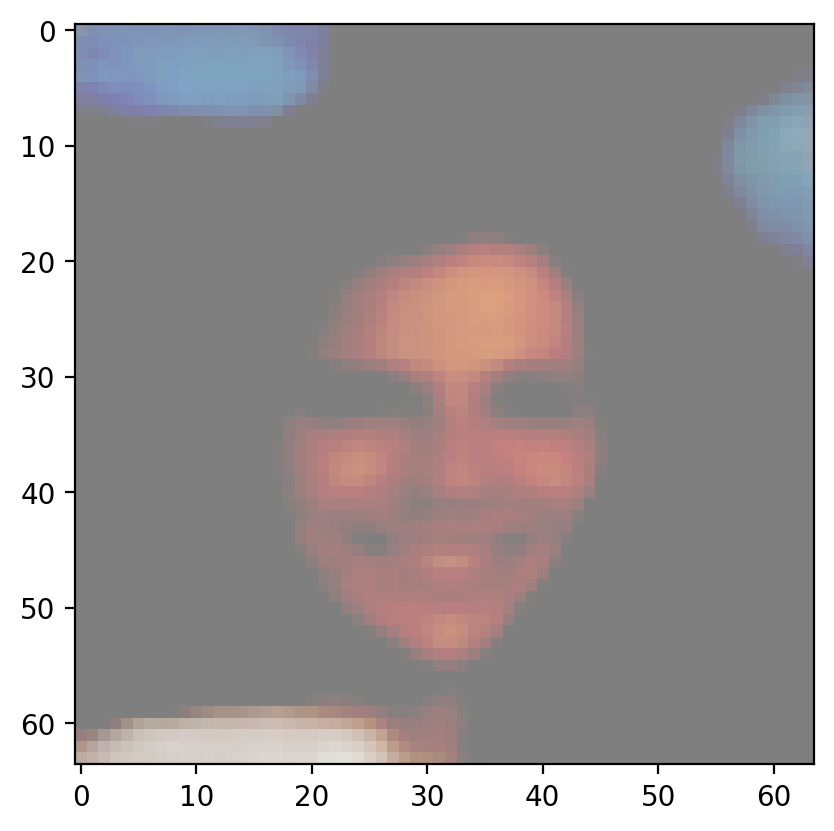

In [51]:
my_vae_scratch_2 = VAE_extended(dimz=50, channels=3, var_x=0.1,lr=1e-3,epochs=100)
my_vae_scratch_2.trainloop(trainloader = trainloader)

z_batch,_,_ = my_vae_scratch_2.encoder.encode_and_sample(i)

x_reconstructed = my_vae_scratch_2.decoder.decode(z_batch).detach() 

# We plot he original image
imshow(i[0,:,:,:])

# And the reconstruction
imshow(x_reconstructed[0,:,:,:])

No solo la loss es notablemente más baja, sino que bajan mucho los artefactos de la imágen reconstruida y vemos un enorme aumento de calidad en la misma, sobretodo en definición y color.

Comprobemos la calidad de generación de imágenes híbridas.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


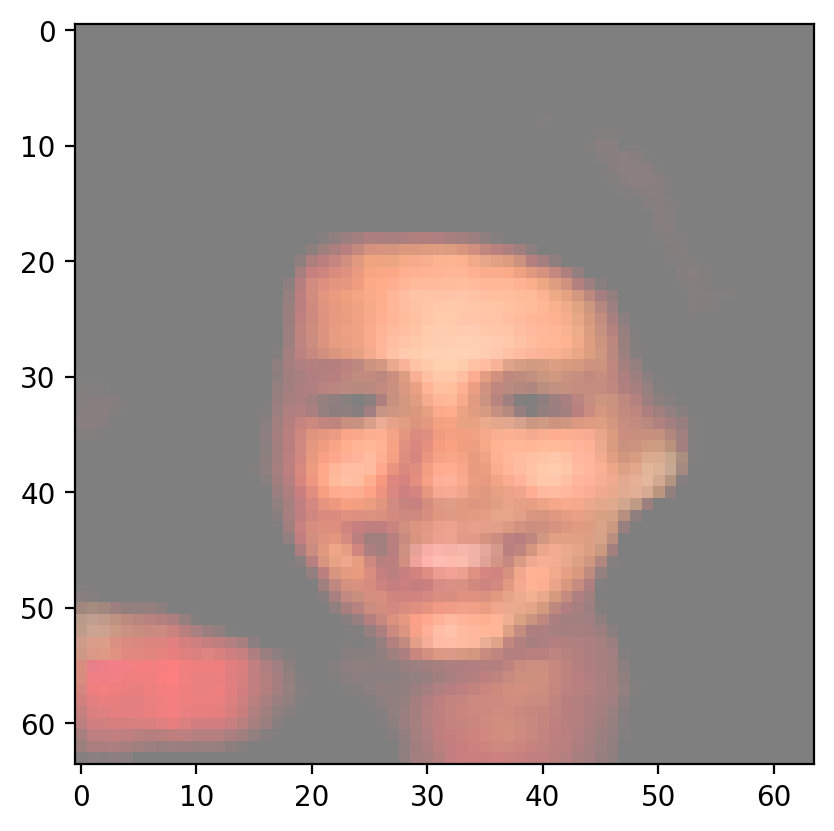

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


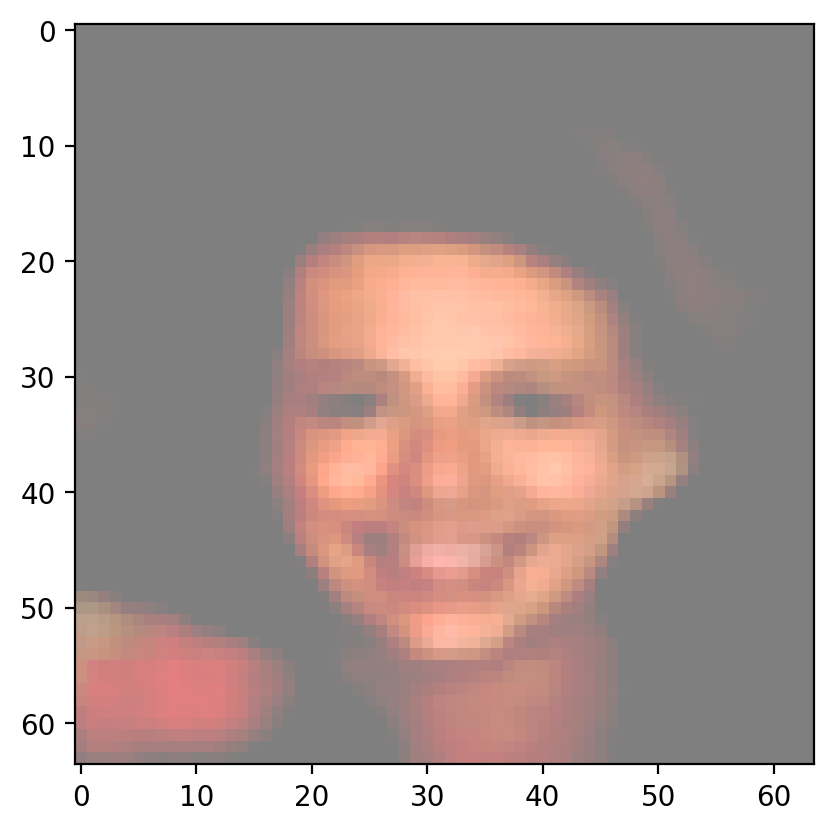

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


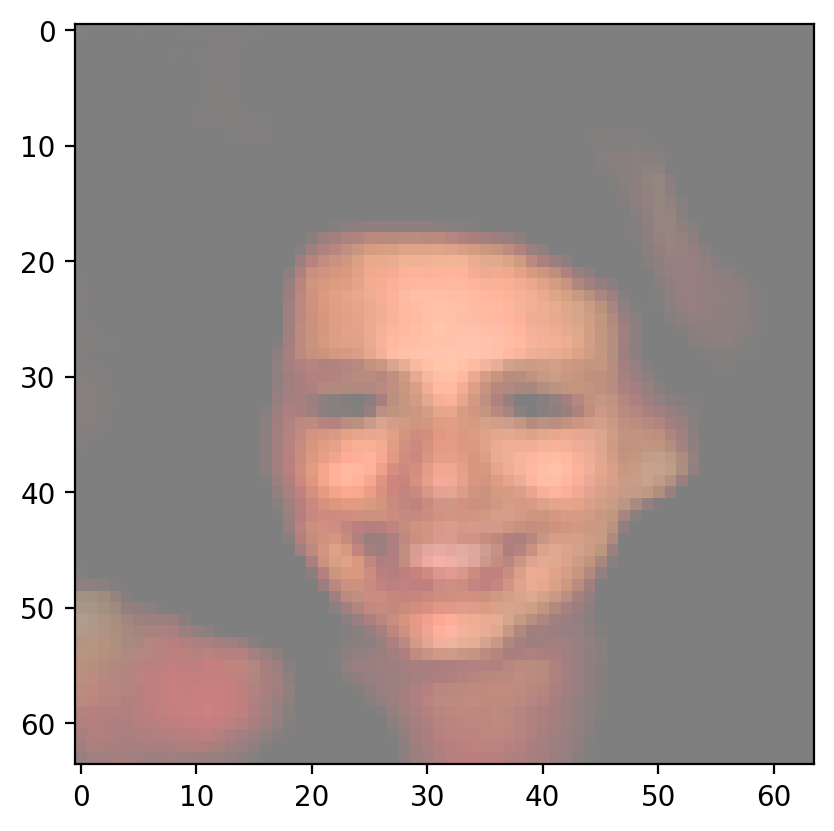

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


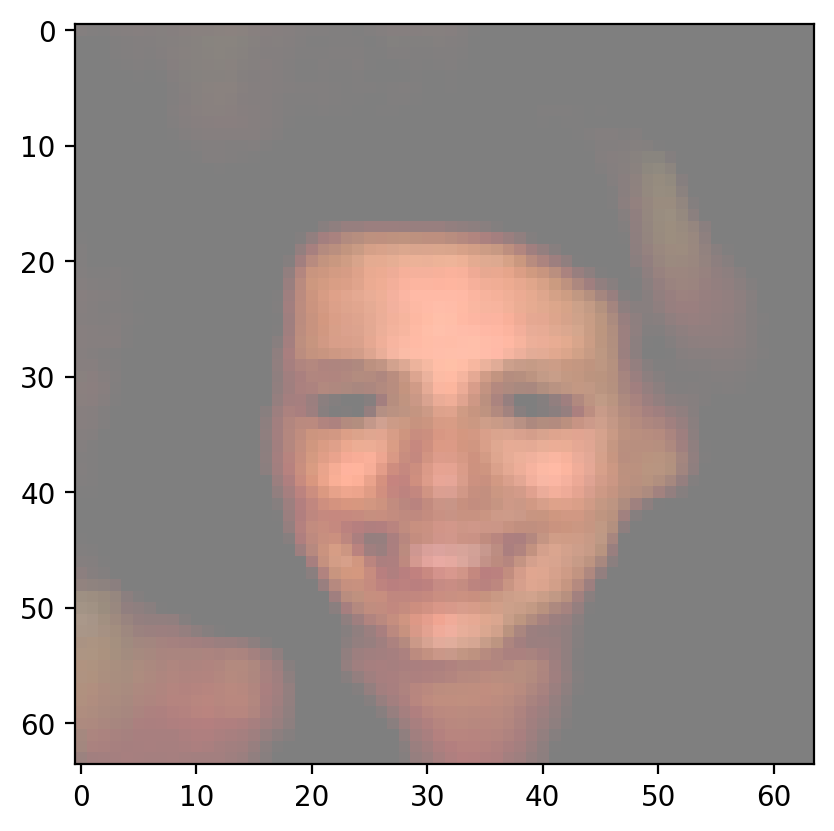

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


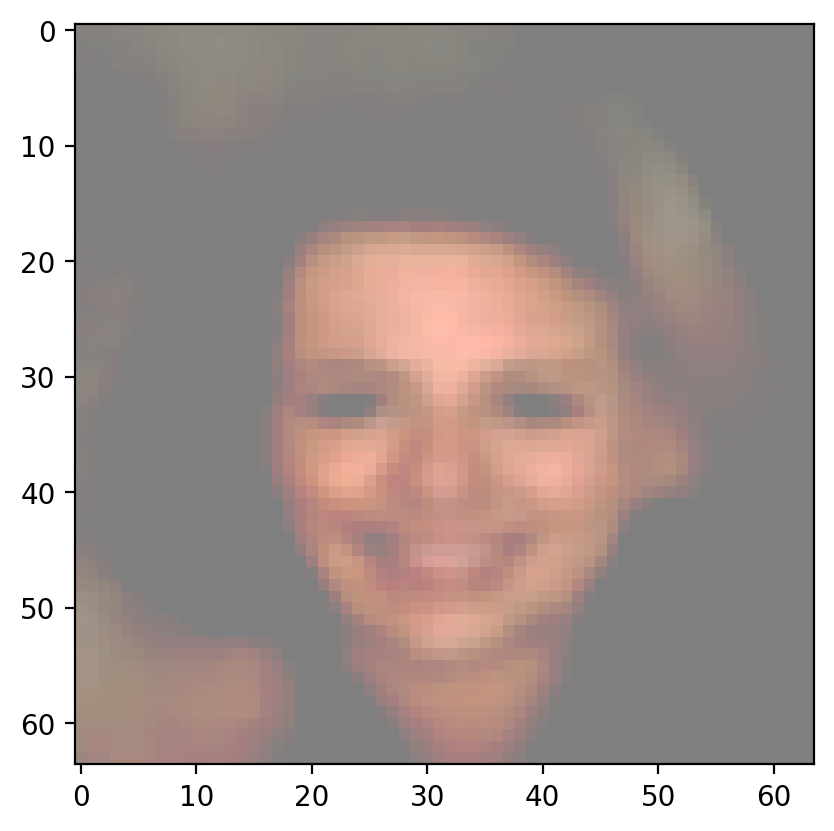

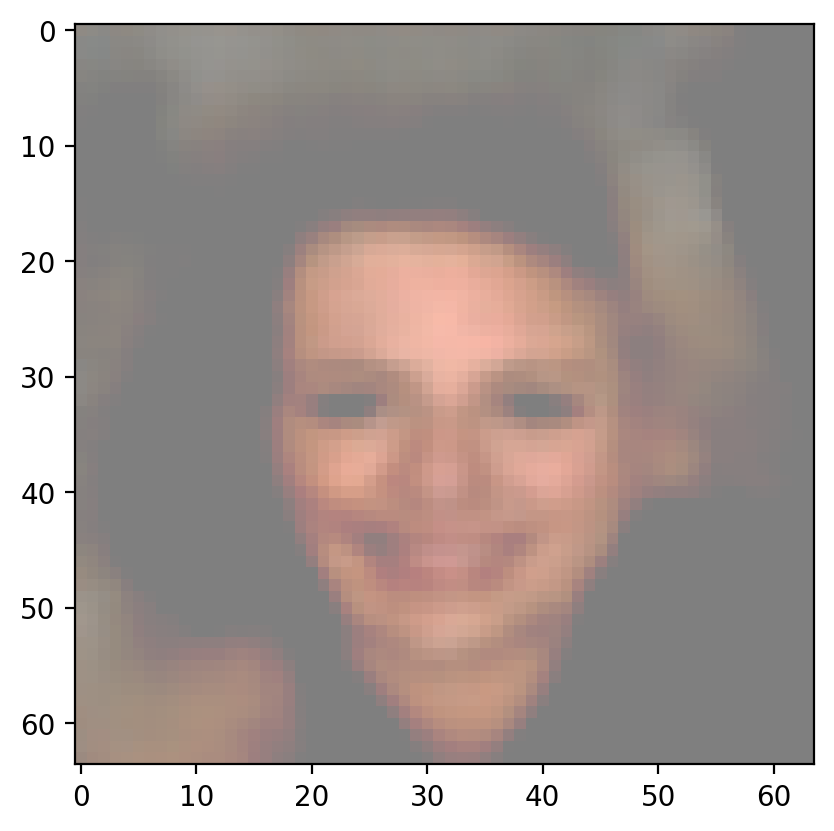

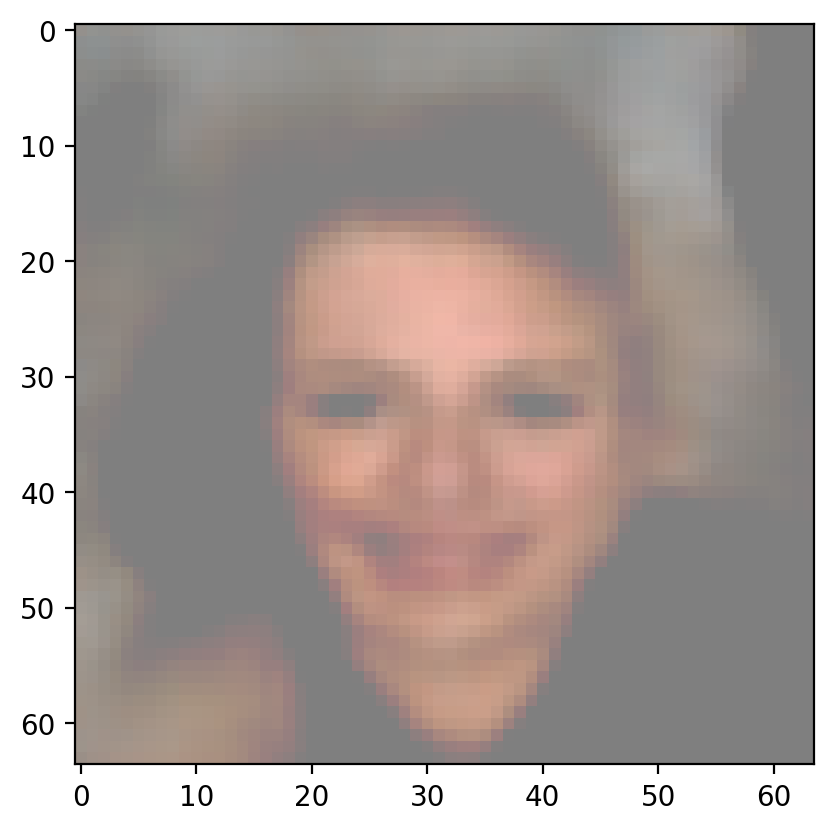

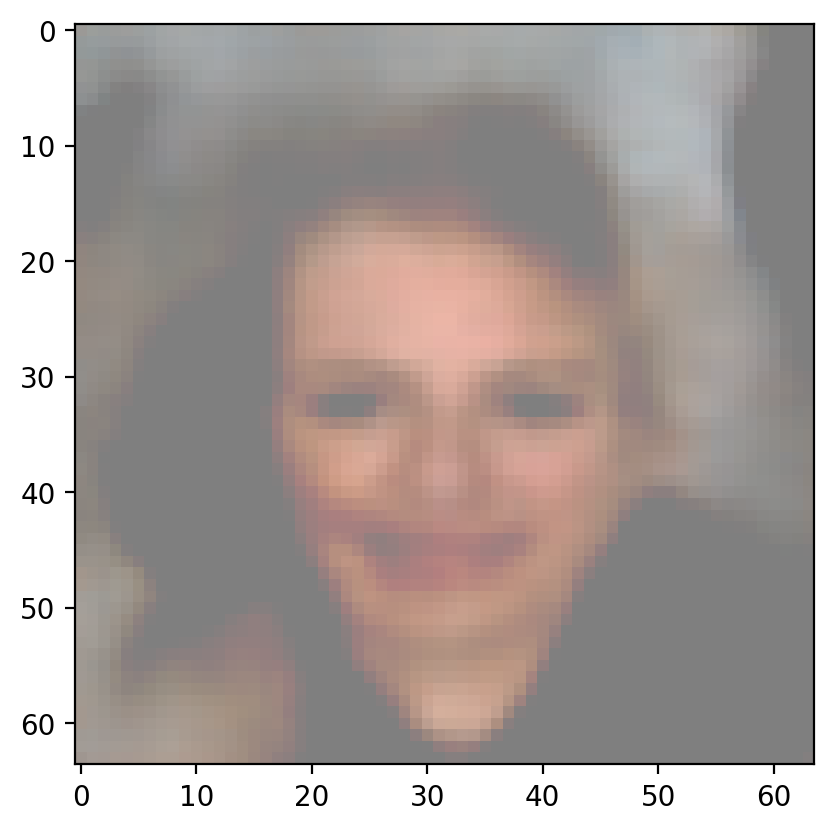

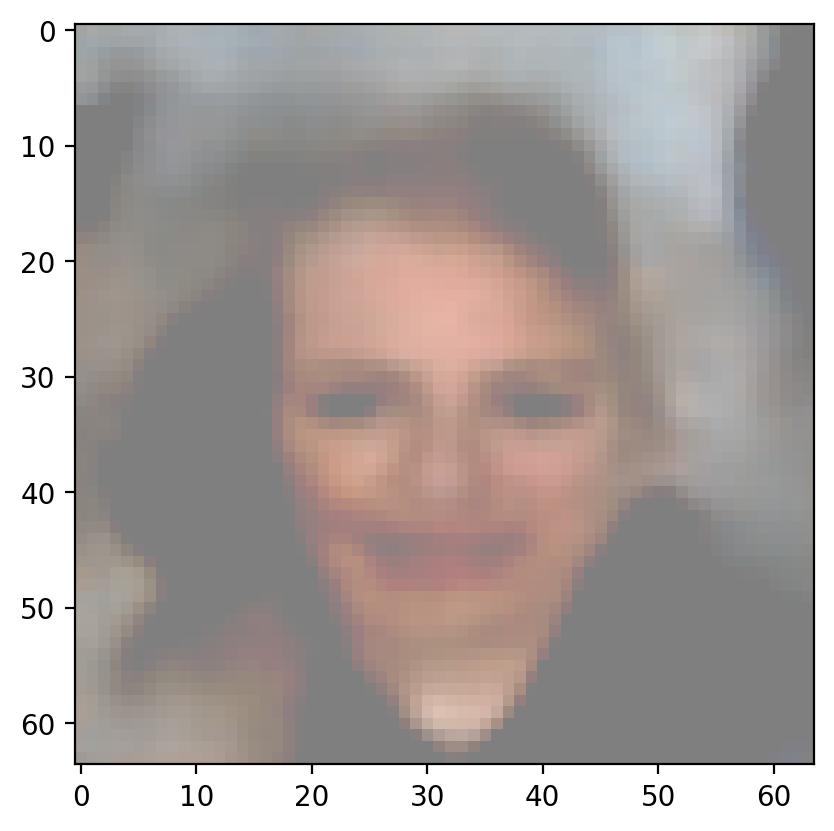

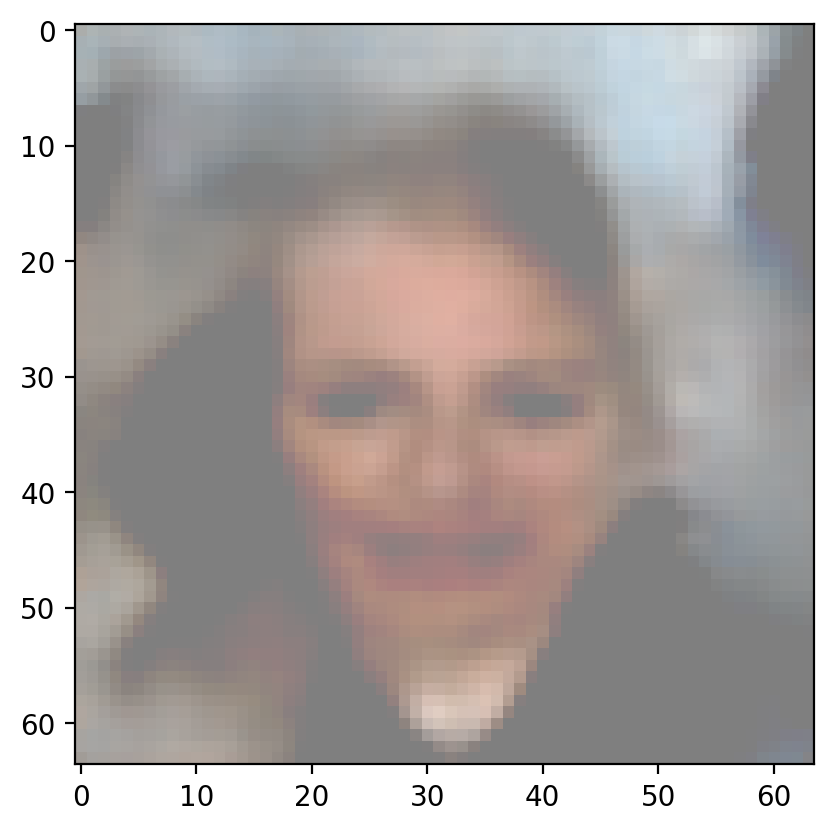

In [52]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0]
z_2 = z_batch[1]

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [my_vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

for im in reconstructed_image:
  imshow(im[0,:,:,:])

De nuevo, se reducen mucho los artefactos, mejora la calidad, el color y la definición así como la mezcla de características de dos imágenes simultaneamente en tan solo 80 épocas de entrenamiento más.